# Libraries

In [40]:
!pip install xgboost 
!pip install yellowbrick
#!pip install seaborn

In [41]:
#Data Manipulation
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy.stats import zscore, loguniform, randint 
import math


#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
colors = ['#c1121f','#669bbc', '#f4d35e', '#e9724c', '#ffc857']
plt.style.use('seaborn-v0_8-whitegrid')
#plt.rc('figure', figsize=(12,8))
#plt.rc('font', size=18)
#plt.rc('axes', labelsize=14, titlesize=14)
#plt.rc('legend', fontsize=14)
#plt.rc('xtick', labelsize=10)
#plt.rc('ytick', labelsize=10)

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


#Models
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

#Metrics and Tuning
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from yellowbrick.regressor import PredictionError, ResidualsPlot

#General
import warnings
warnings.filterwarnings(action='ignore')

# Connecting to our BigQuery Data Warehouse.

* The connection to my bigquery data warehouse datesets is done through importing the bigquery api from the google cloud library.
* Then we can utilize the client object to run the query saved in the variable sql.
* Finally the query output is then converted to data frame for our analysis.

In [ ]:
from google.cloud import bigquery
client = bigquery.Client()

sql = """
    SELECT 
c.country_code,
c.country_name,
c.region,
c.population,
s.status,
d.year,
d.leap_year,
d.decade,
i.income_group_code,
i.income_group,
le.life_expectancy,
le.adult_mortality,
le.infant_deaths,
le.alcohol,
le.percentage_expenditure,
le.hepatitis_b,
le.measles,
le.bmi,
le.under_five_deaths, le.polio, 
le.total_expenditure, le.diphtheria, le.HIV_AIDS, le.GDP, 
le.thinness_10_19_years, le.thinness_5_9_years, 
le.income_composition_of_resources, le.schooling, le.education_expenditure
FROM
finalproject-38931.LE_DATA_WAREHOUSE.LE_FACT_TABLE le
JOIN 
finalproject-38931.LE_DATA_WAREHOUSE.COUNTRY_DIM c
ON le.country_id = c.country_id
JOIN
finalproject-38931.LE_DATA_WAREHOUSE.COUNTRY_STATUS_DIM s
ON le.country_status_id = s.country_status_id
JOIN
finalproject-38931.LE_DATA_WAREHOUSE.DATE_DIM d
ON le.year = d.year
JOIN
finalproject-38931.LE_DATA_WAREHOUSE.INCOME_GROUP_DIM i
ON le.income_group_id = i.income_group_id
ORDER BY
le.le_fact_table_id;

"""

df_le = client.query(sql).to_dataframe()

#Printing out the number of rows and Columns of our dataframes
print('------ Dataset ------')
print(f'Number of rows: {df_le.shape[0]}')
print(f'Number of columns: {df_le.shape[1]}')
print('')

#Displays the first 10 rows of our dataframes
df_le.head(10)


# Life Expectancy Exploratory Data Analysis 

In [43]:
#Checking the datatypes and non-null count
df_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country_code                     2938 non-null   object 
 1   country_name                     2938 non-null   object 
 2   region                           2938 non-null   object 
 3   population                       2286 non-null   float64
 4   status                           2938 non-null   object 
 5   year                             2938 non-null   Int64  
 6   leap_year                        2938 non-null   boolean
 7   decade                           2938 non-null   Int64  
 8   income_group_code                2938 non-null   object 
 9   income_group                     2938 non-null   object 
 10  life_expectancy                  2928 non-null   float64
 11  adult_mortality                  2928 non-null   float64
 12  infant_deaths       

In [44]:
# Checking for actual number of missing values
print('Missing Values:')
print(df_le.isnull().sum())
print('\n')

Missing Values:
country_code                         0
country_name                         0
region                               0
population                         652
status                               0
year                                 0
leap_year                            0
decade                               0
income_group_code                    0
income_group                         0
life_expectancy                     10
adult_mortality                     10
infant_deaths                        0
alcohol                            194
percentage_expenditure               0
hepatitis_b                        553
measles                              0
bmi                                 34
under_five_deaths                    0
polio                               19
total_expenditure                  226
diphtheria                          19
HIV_AIDS                             0
GDP                                448
thinness_10_19_years                34
thinness_

* From the above we have 6 object columns, 1 boolean, and 22 numerical columns consisting of floats and integers.
* The 6 object columns are categorical data
* It is also clear that we have serveral columns with missing values with the highest column with missing values being Education expenditure with 890 missing values.

## Now lets find insights from both the Categorical and Numerical data from our datasets

## Insights from Categorical data

* I start by grouping the dataframe using the unique values of the Income Group feature.
* I want to see if there would be any relationship that further cements the fact that Income of countries affect Life Expectancy.

In [45]:
#New dataframes
df_low_income = df_le.loc[df_le['income_group']=='Low income'].copy()
df_upper_middle_income = df_le.loc[df_le['income_group']=='Upper middle income'].copy()
df_lower_middle_income = df_le.loc[df_le['income_group']=='Lower middle income'].copy()
df_high_income = df_le.loc[df_le['income_group']=='High income'].copy()

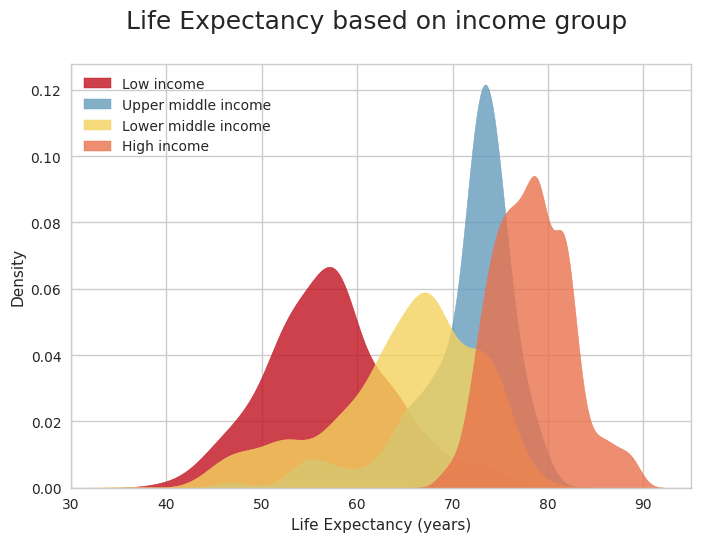

In [46]:
# Plot the density of life expectancy by country status
sns.kdeplot(df_low_income['life_expectancy'],  # Plot the density of life expectancy for Low income countries
            label='Low income',  # Label the Low income countries' density plot
            fill=True,  # Fill the area under the density curve
            color = colors[0],  # Set the color of the Low income countries' density plot
            alpha = 0.8)  # Set the transparency of the Low income countries' density plot

sns.kdeplot(df_upper_middle_income['life_expectancy'],  # Plot the density of life expectancy for Upper middle income countries
            label='Upper middle income',  # Label the Upper middle income countries' density plot
            fill=True,  # Fill the area under the density curve
            color=colors[1],  # Set the color of the Upper middle income countries' density plot
            alpha = 0.8)  # Set the transparency of the Upper middle income countries' density plot

sns.kdeplot(df_lower_middle_income['life_expectancy'],  # Plot the density of life expectancy for Lower middle income countries
            label='Lower middle income',  # Label the Lower middle income countries' density plot
            fill=True,  # Fill the area under the density curve
            color = colors[2],  # Set the color of the Lower middle income countries' density plot
            alpha = 0.8)  # Set the transparency of the Lower middle income countries' density plot

sns.kdeplot(df_high_income['life_expectancy'],  # Plot the density of life expectancy for High income countries
            label='High income',  # Label the High income countries' density plot
            fill=True,  # Fill the area under the density curve
            color = colors[3],  # Set the color of the High income countries' density plot
            alpha = 0.8)  # Set the transparency of the High income countries' density plot

plt.legend(loc='upper left')  # Add a legend to the plot
plt.ylabel('Density')  # Label the y-axis as "Density"
plt.xlim(30,95)  # Set the limits of the x-axis
plt.xlabel('Life Expectancy (years)')  # Label the x-axis as "Life Expectancy (years)"
plt.title('Life Expectancy based on income group \n', fontsize=18);  # Set the title of the plot

* From the plot above we can clearly see that High Income group countries have an average Life Expectancy around 67 to 95 whiles upper middle income having the highest desity spans across 45-82, Lower Middle Income between 40-81 and lastly, Lower Income 35-75.
* These findings may be due to a number of reasons since the determinants of Income Group of a country may consist of different factors for which our numerical features also play a vital role in.

* We further drill down on the categrical feature called Status which defines the country status as being developed or developing.

In [47]:
#New dataframes
df_developed = df_le.loc[df_le['status']=='Developed'].copy()
df_developing = df_le.loc[df_le['status']=='Developing'].copy()

In [48]:
#df_developed['year'] = pd.to_numeric(df_developed['year'])
df_developing['year'] = pd.to_numeric(df_developing['year'])

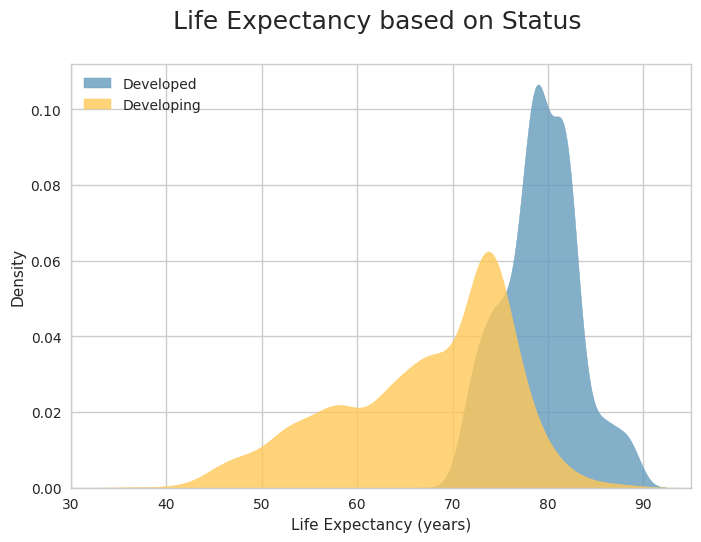

In [49]:
# Plot the density of life expectancy by country status
sns.kdeplot(df_developed['life_expectancy'],  # Plot the density of life expectancy for developed countries
            label='Developed',  # Label the developed countries' density plot
            fill=True,  # Fill the area under the density curve
            color = colors[1],  # Set the color of the developed countries' density plot
            alpha = 0.8)  # Set the transparency of the developed countries' density plot

sns.kdeplot(df_developing['life_expectancy'],  # Plot the density of life expectancy for developing countries
            label='Developing',  # Label the developing countries' density plot
            fill=True,  # Fill the area under the density curve
            color=colors[4],  # Set the color of the developing countries' density plot
            alpha = 0.8)  # Set the transparency of the developing countries' density plot

plt.legend(loc='upper left')  # Add a legend to the plot
plt.ylabel('Density')  # Label the y-axis as "Density"
plt.xlim(30,95)  # Set the limits of the x-axis
plt.xlabel('Life Expectancy (years)')  # Label the x-axis as "Life Expectancy (years)"
plt.title('Life Expectancy based on Status \n', fontsize=18);  # Set the title of the plot

* From the above plot of Life Expectancy based on Status we see again that for status of developed, they have very high life expectancy ranging from 68-95. 
* Also the status of developed countries turn to have very high density compared to that of Developing which has a wider range of  life expactincy from 35 spreading all the way to 92

### After finding certain insight above, we still want to go further to find out whether these insight are the same in a year or they vary each yeear averagely for life expectancy.

In [50]:
#Converting the year column from integer to float to enable uniformity of the data to be plotted.
df_developed['year'] = df_developed['year'].astype(float)
df_developing['year'] = df_developing['year'].astype(float)


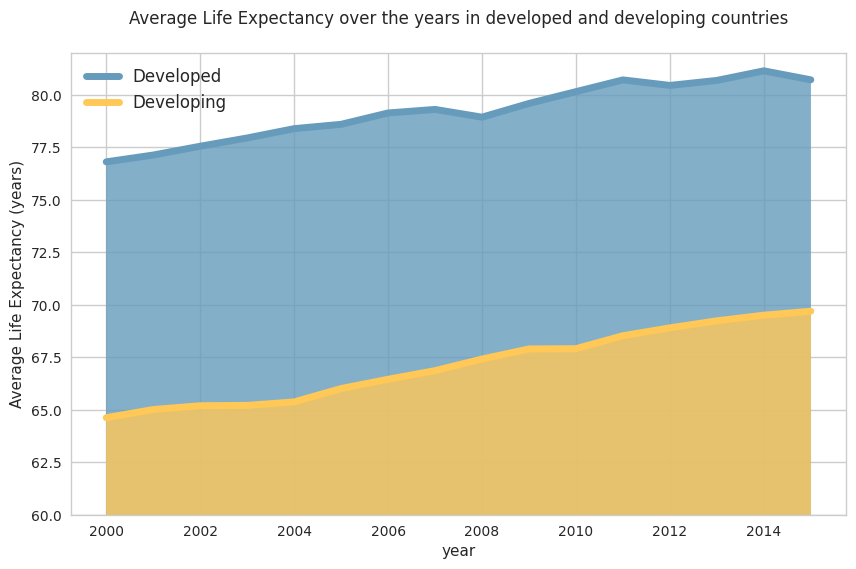

In [51]:

# Plot average Life Expectancy over the years
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df_developed.groupby('year')['life_expectancy'].mean(),
       label='Developed',
       color=colors[1],
       linewidth=5)

# Fill area between the line plot and the x-axis
ax.fill_between(df_developed.groupby('year')['life_expectancy'].mean().index,
                df_developed.groupby('year')['life_expectancy'].mean().values,
                color=colors[1],
                alpha=0.8) 

ax.plot(df_developing.groupby('year')['life_expectancy'].mean(),
       label='Developing',
       color=colors[4],
       linewidth=5,)

ax.fill_between(df_developing.groupby('year')['life_expectancy'].mean().index,
                df_developing.groupby('year')['life_expectancy'].mean().values,
                color=colors[4],
                alpha=0.8) 

plt.legend(loc='upper left', fontsize=12)
ax.set_xlabel('year')
ax.set_ylabel('Average Life Expectancy (years)')

# Set y-axis limits
ax.set_ylim(60,82)

ax.set_title('Average Life Expectancy over the years in developed and developing countries\n');

* We notice from above plot that for Countries that are developed, overall there is an up trend from left to right in the average Life Expectency.

* However, this up trend dipped in 2008 and 2012. After extensive research on these dates, I can fairly say this could have been the effects of the Great Recession that hit the world financial sector and its aftermath effects like major unemployment.

* Likewise, Countries that are developing also show an up trend from left to right overall of the average Life expectancy over these years.
* However, the notice the effects of the Great recession which lasted from December 2007 to 2009 having an aftermath effect during 2010 causing a slight dip. 

* Also we notice a faint dip during 2004 which I can only speculate was as a result of devastating series of tsunamis caused by an earthquake in Indonesia's coast, which lead to about 228,000 deaths and over millions displaced in 14 countries along the Indian Ocean.

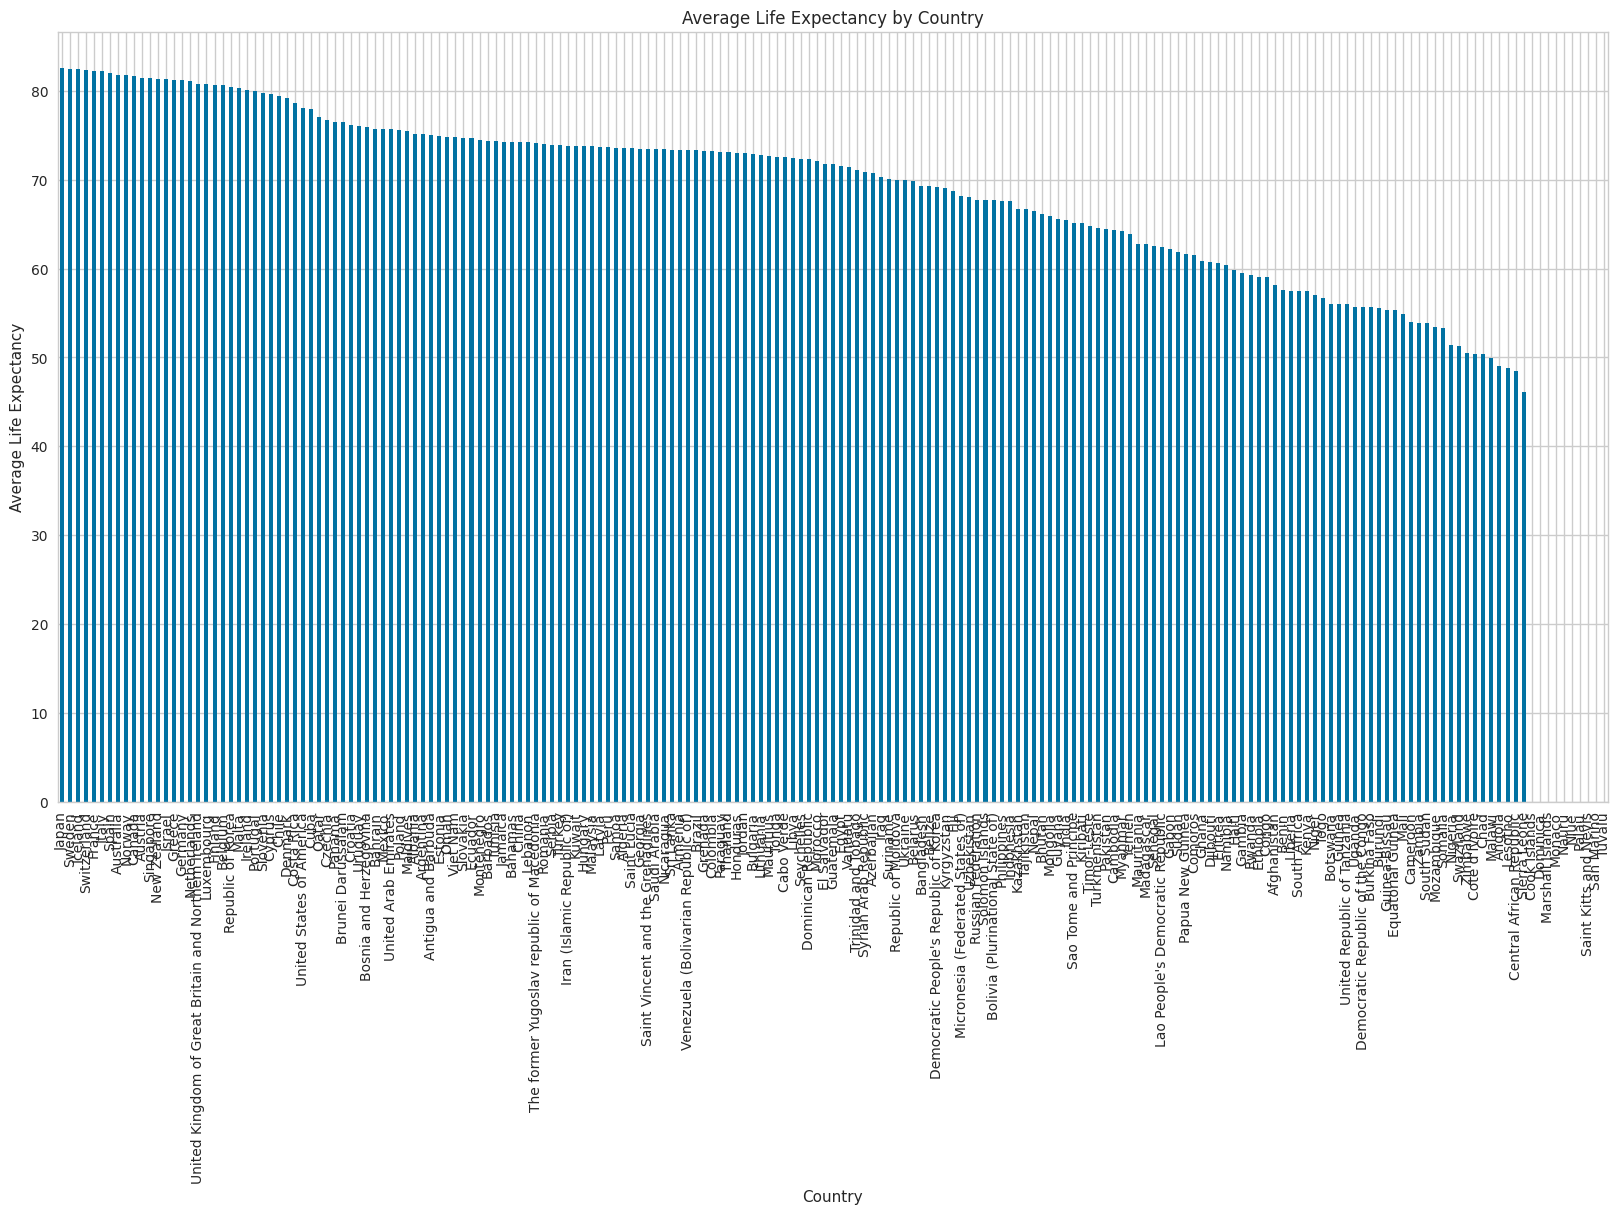

In [52]:
# Bar plot for 'country_name' column
plt.figure(figsize=(20,10))
df_le.groupby('country_name')['life_expectancy'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Average Life Expectancy by Country')
plt.ylabel('Average Life Expectancy')
plt.xlabel('Country')
plt.show()

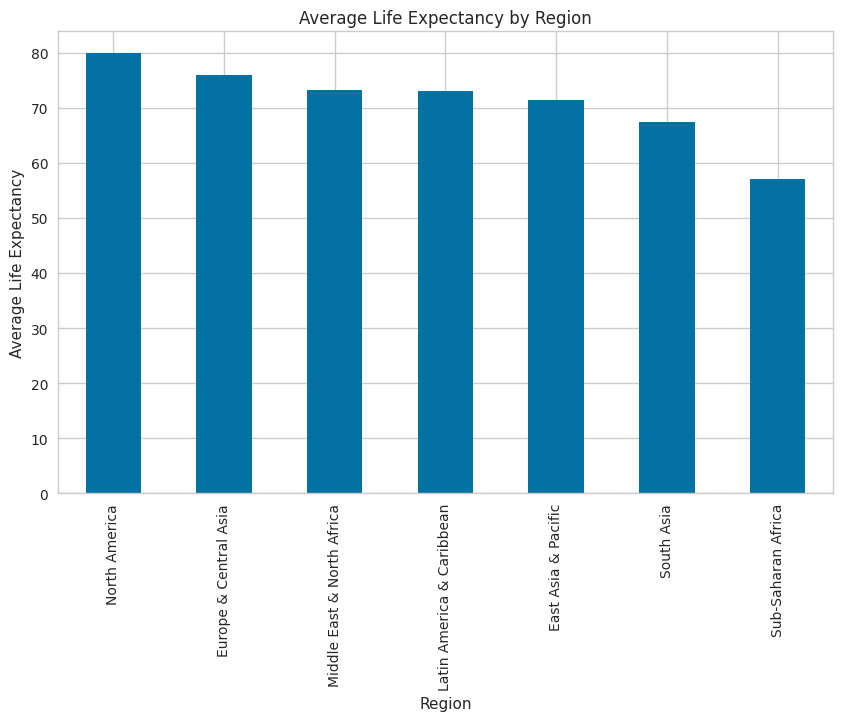

In [53]:
# Bar plot for 'region' column
plt.figure(figsize=(10,6))
df_le.groupby('region')['life_expectancy'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Average Life Expectancy by Region')
plt.ylabel('Average Life Expectancy')
plt.xlabel('Region')
plt.show()

## Insights from Numerical data
### Overall distribution of the numerical features

We are going to plot histograms for all the numerical features. 
Then we are going to plot a matrix of correlation for the numerical features and use those correlations to further explore the dataset

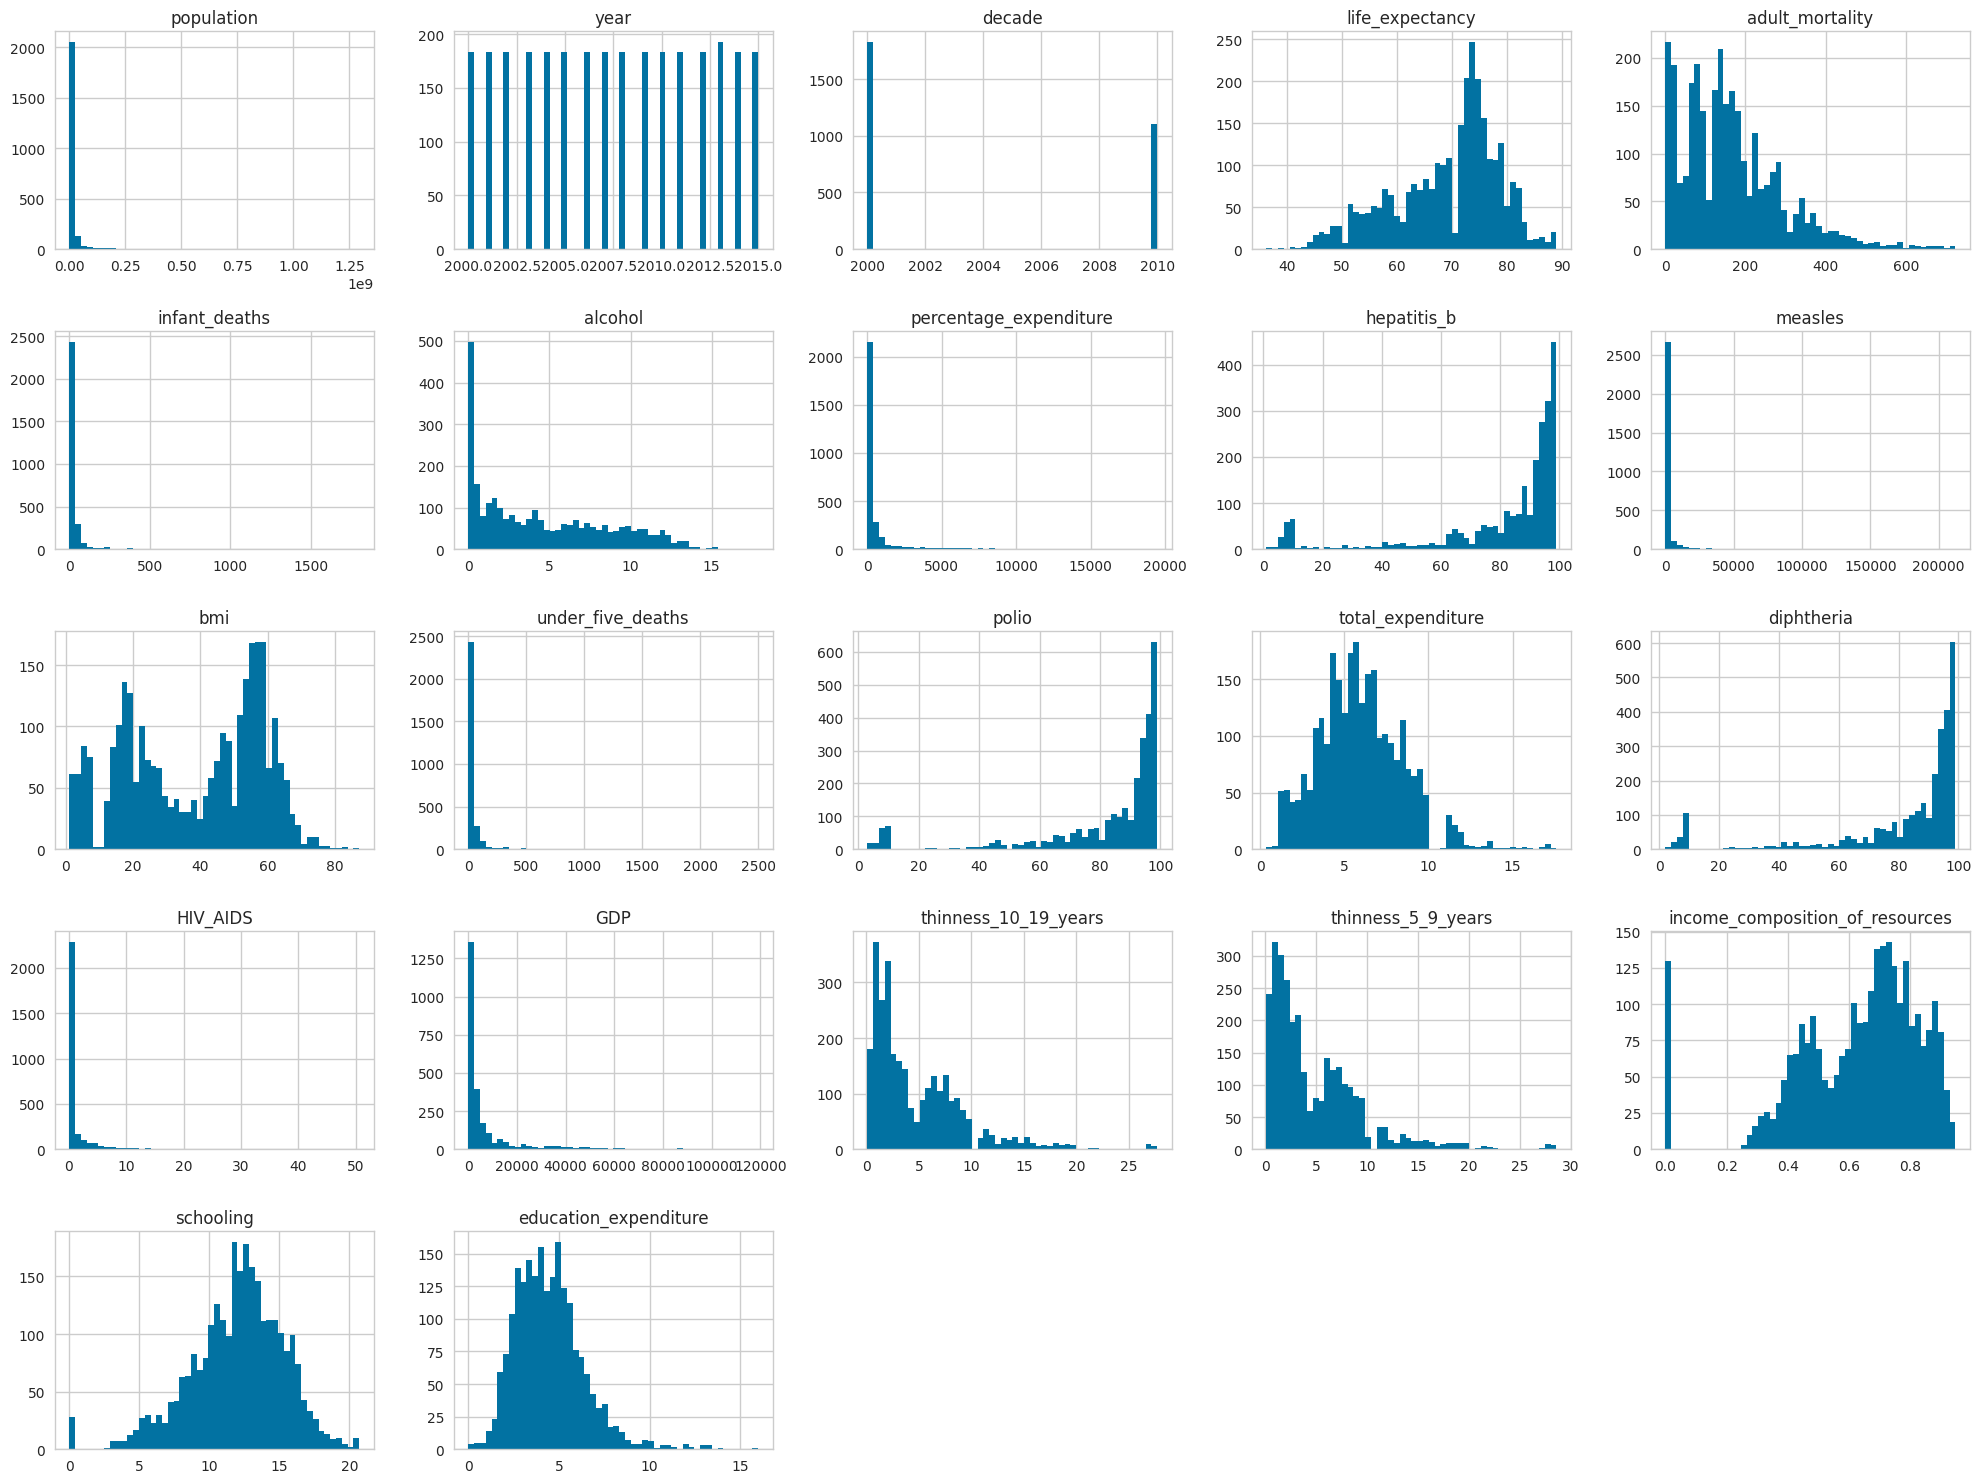

In [54]:
# Plotting histograms for the numerical columns
df_le.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Features Correlation Matrix Heatmap')

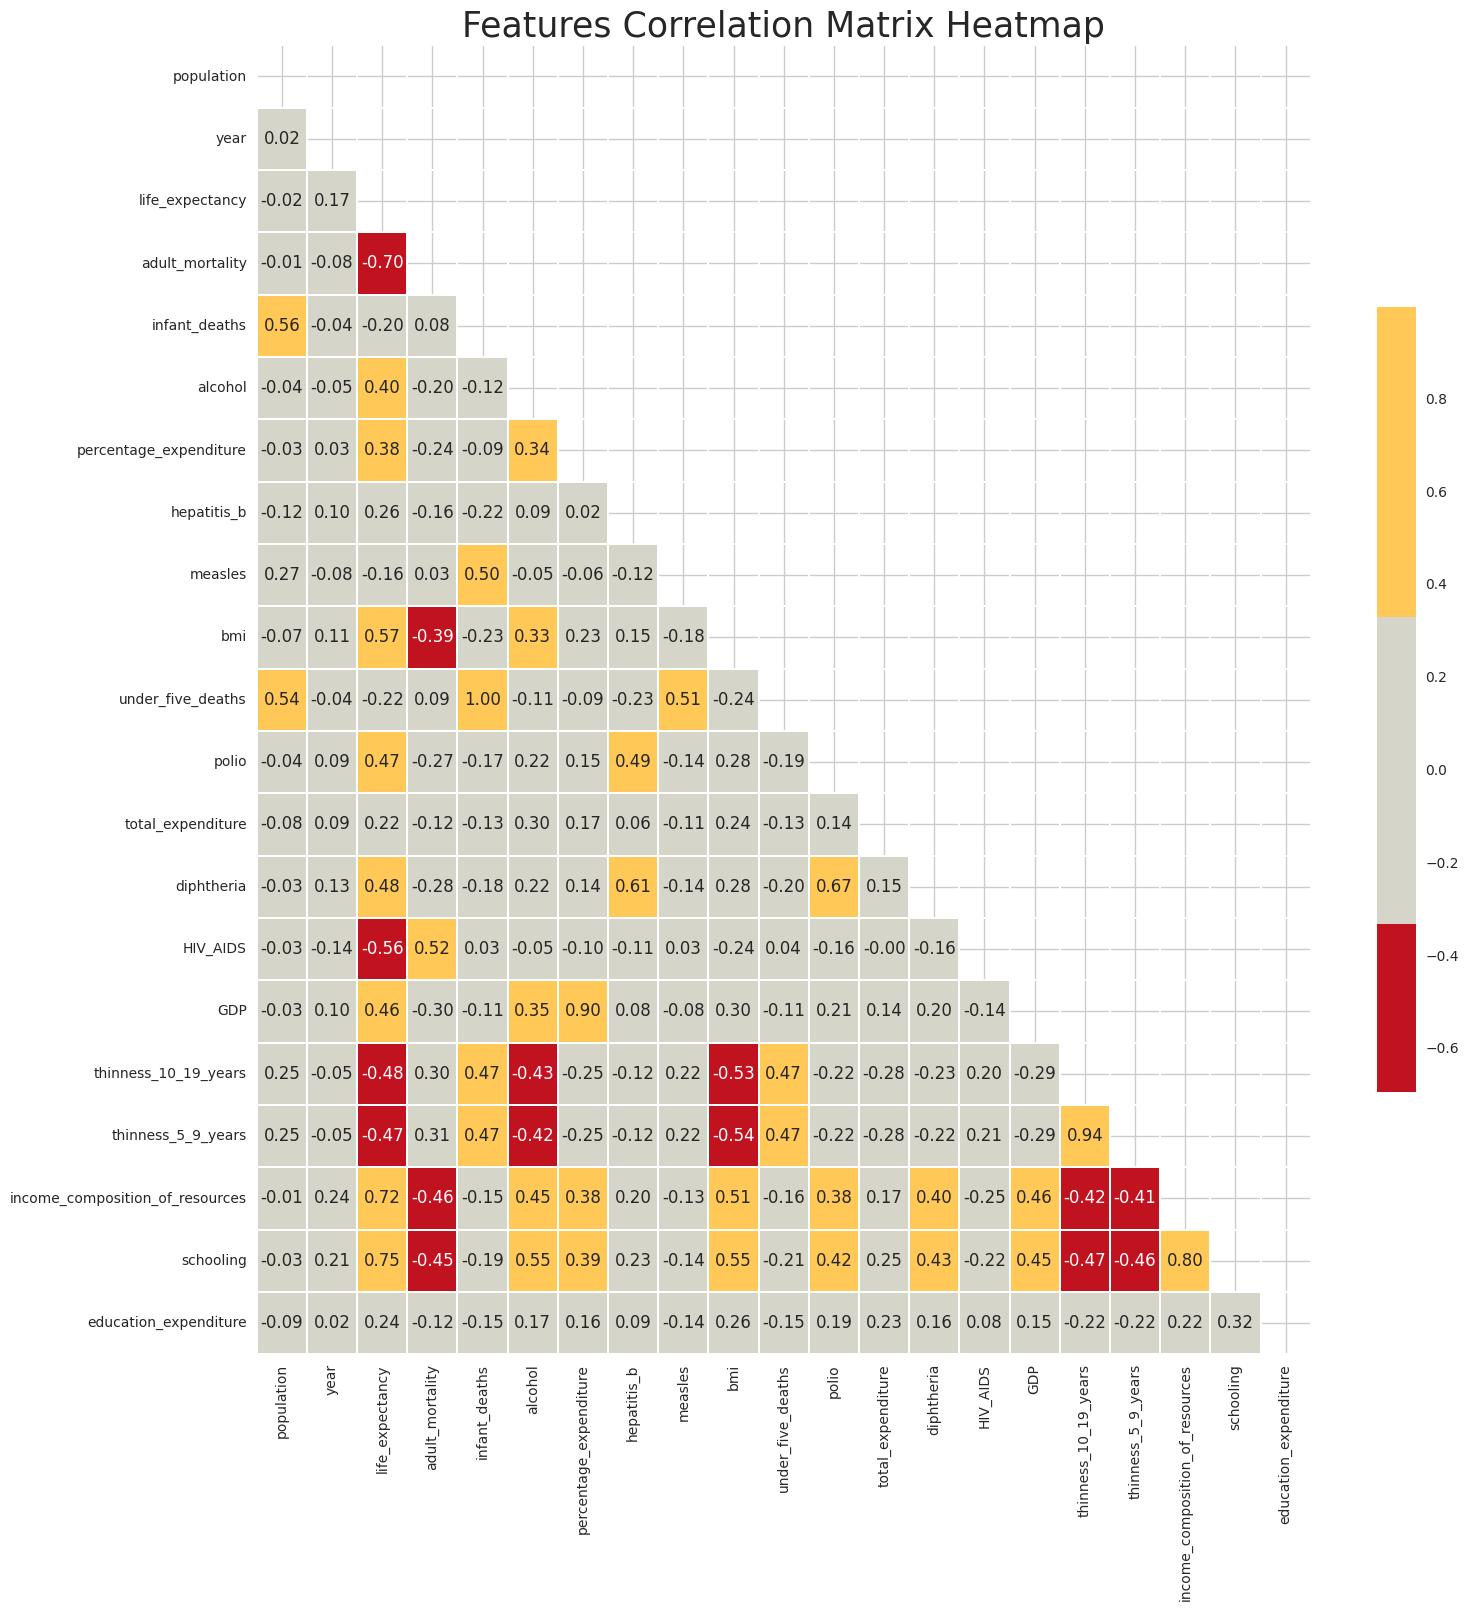

In [55]:
#Plot Matrix of Correlation
numerical_features = ['population', 'year', 'life_expectancy', 'adult_mortality', 'infant_deaths', 'alcohol', 
                      'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi', 'under_five_deaths', 
                      'polio', 'total_expenditure', 'diphtheria', 'HIV_AIDS', 'GDP', 'thinness_10_19_years', 
                      'thinness_5_9_years', 'income_composition_of_resources', 'schooling', 'education_expenditure']

df_numerical = df_le[numerical_features]

# Plot Matrix of Correlation
plt.figure(figsize=(17,17))

heatmap_colors = [colors[0], '#d6d5c9', colors[4]]

corr = df_numerical.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, center=0, annot=True, fmt='.2f', cmap=heatmap_colors, square=True, 
            linewidths=.2, cbar_kws={'shrink': .6})

plt.title('Correlation Matrix Heatmap of Features', fontsize=25)

- The heatmap correlation shows that the features 'schooling', 'income_composition_of_resources', and 'bmi', have a high positve correlation with the target and the features 'Adult mortality' and 'HIV/AIDS' have a high negative correlation.
- It is worth noting that the features 'Schooling' and 'Income composition of resources' also have a high correlation between them, as do 'Adult mortality' and 'HIV/AIDS'.
- Although some features do not have a high correlation with the target, it is important to visualize these relationships graphically. As Pandas `corr()` method calculates Pearson correlation between features, which only measures linear relationships and may not capture other types of relationships that the target may have with the other metrics.

In [56]:
# Define the features with positive and negative correlation
positive_corr = ['schooling', 'income_composition_of_resources', 'bmi', 'diphtheria', 'polio', 
                 'percentage_expenditure', 'GDP', 'alcohol', 'total_expenditure', 'education_expenditure']
negative_corr = ['HIV_AIDS','under_five_deaths', 'infant_deaths','thinness_5_9_years', 'thinness_10_19_years', 'adult_mortality']

for col in negative_corr:
    df_le[col] = df_le[col].astype(float)

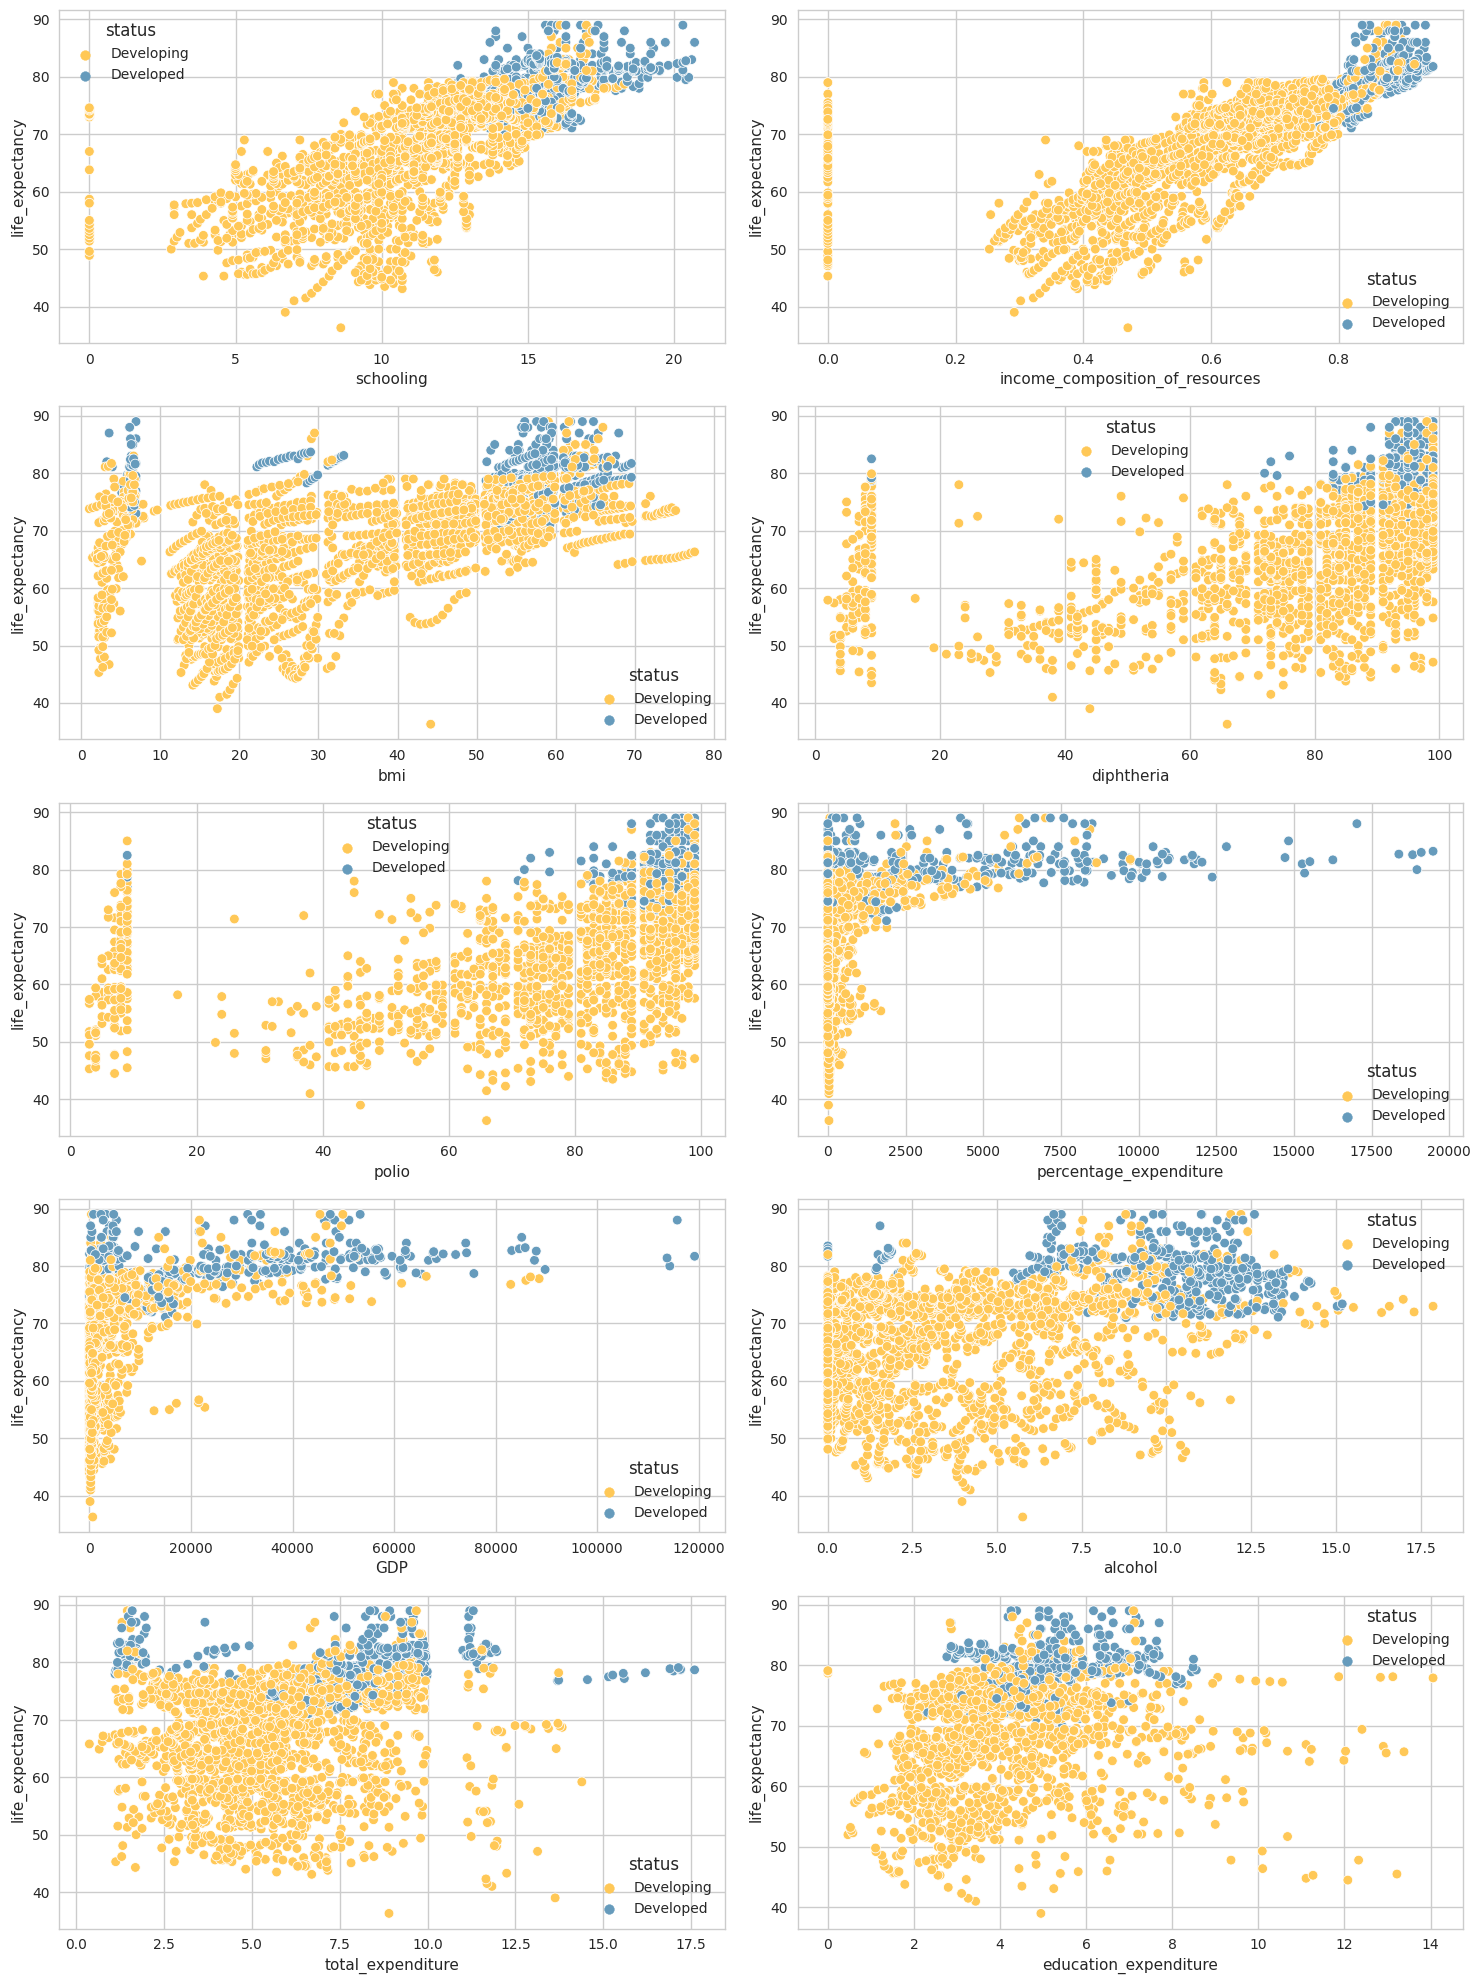

In [57]:
# Positive correlations
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.ravel()
for i, column in enumerate(positive_corr):
    sns.scatterplot(data=df_le, x=column, y='life_expectancy', hue='status', palette=[colors[4], colors[1]], ax=axs[i])
plt.tight_layout()
plt.show()

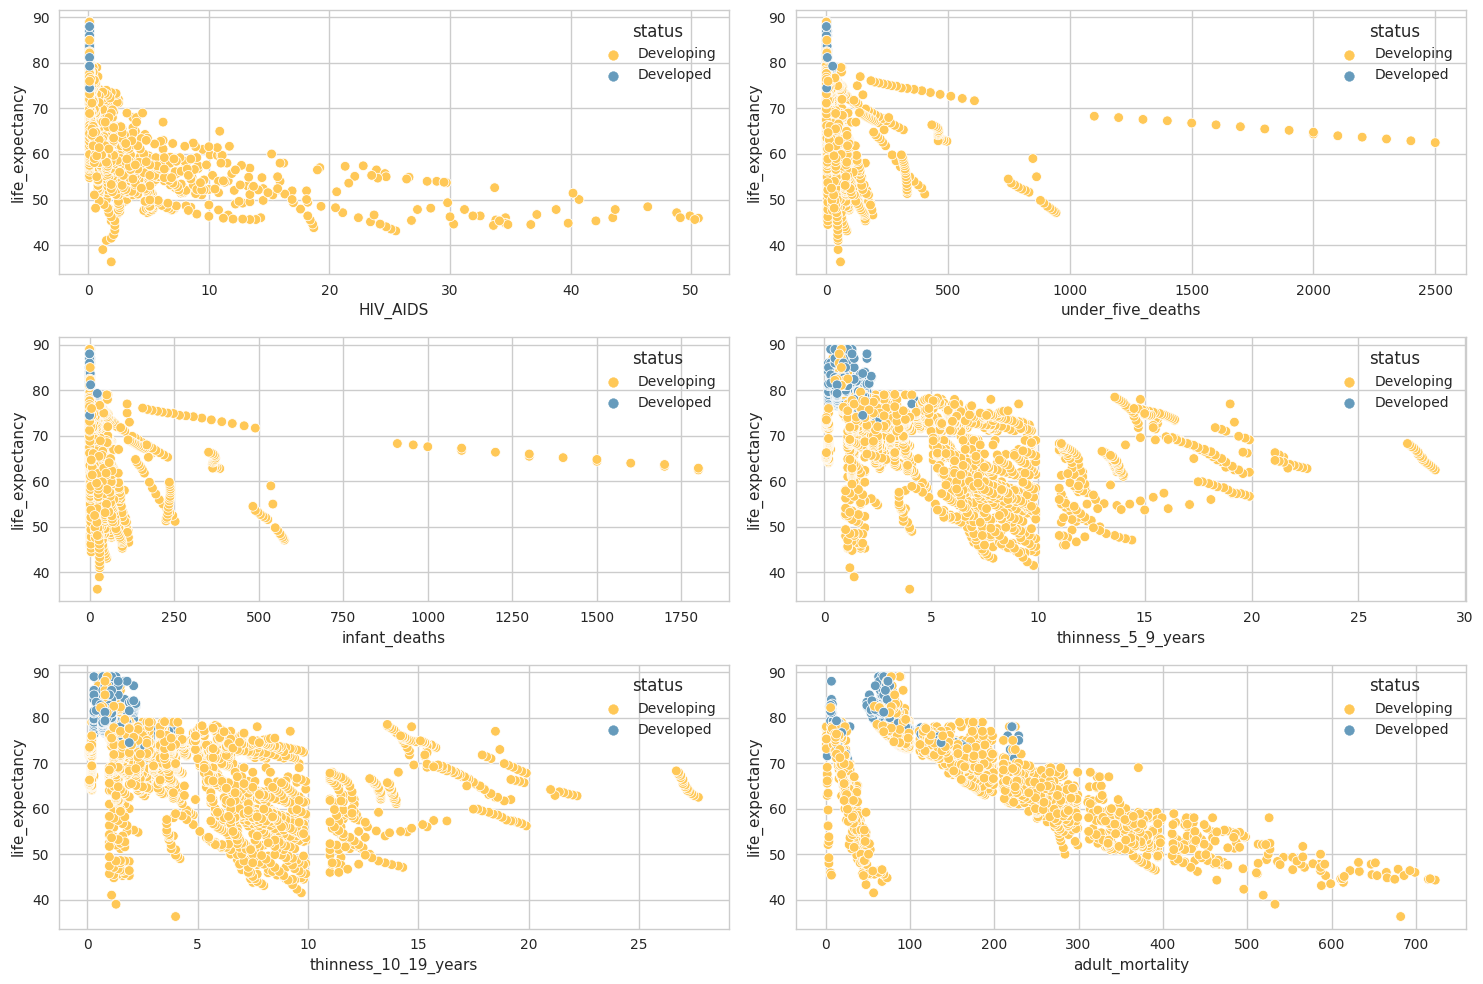

In [58]:
# Negative correlations
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.ravel()
for i, column in enumerate(negative_corr):
    sns.scatterplot(data=df_le, x=column, y='life_expectancy', hue='status', palette=[colors[4], colors[1]], ax=axs[i])
plt.tight_layout()
plt.show()

* These plots show the distribution of the features for different statuses (Developed and Developing). We can observe how these features vary for different statuses and their impact on life expectancy.

* For example, in the positive correlations, we can see that developed countries tend to have higher schooling, income composition of resources, and GDP, which are positively correlated with life expectancy. On the other hand, in the negative correlations, we can see that developed countries tend to have lower HIV/AIDS rates and thinness in 5-9 years, which are negatively correlated with life expectancy.

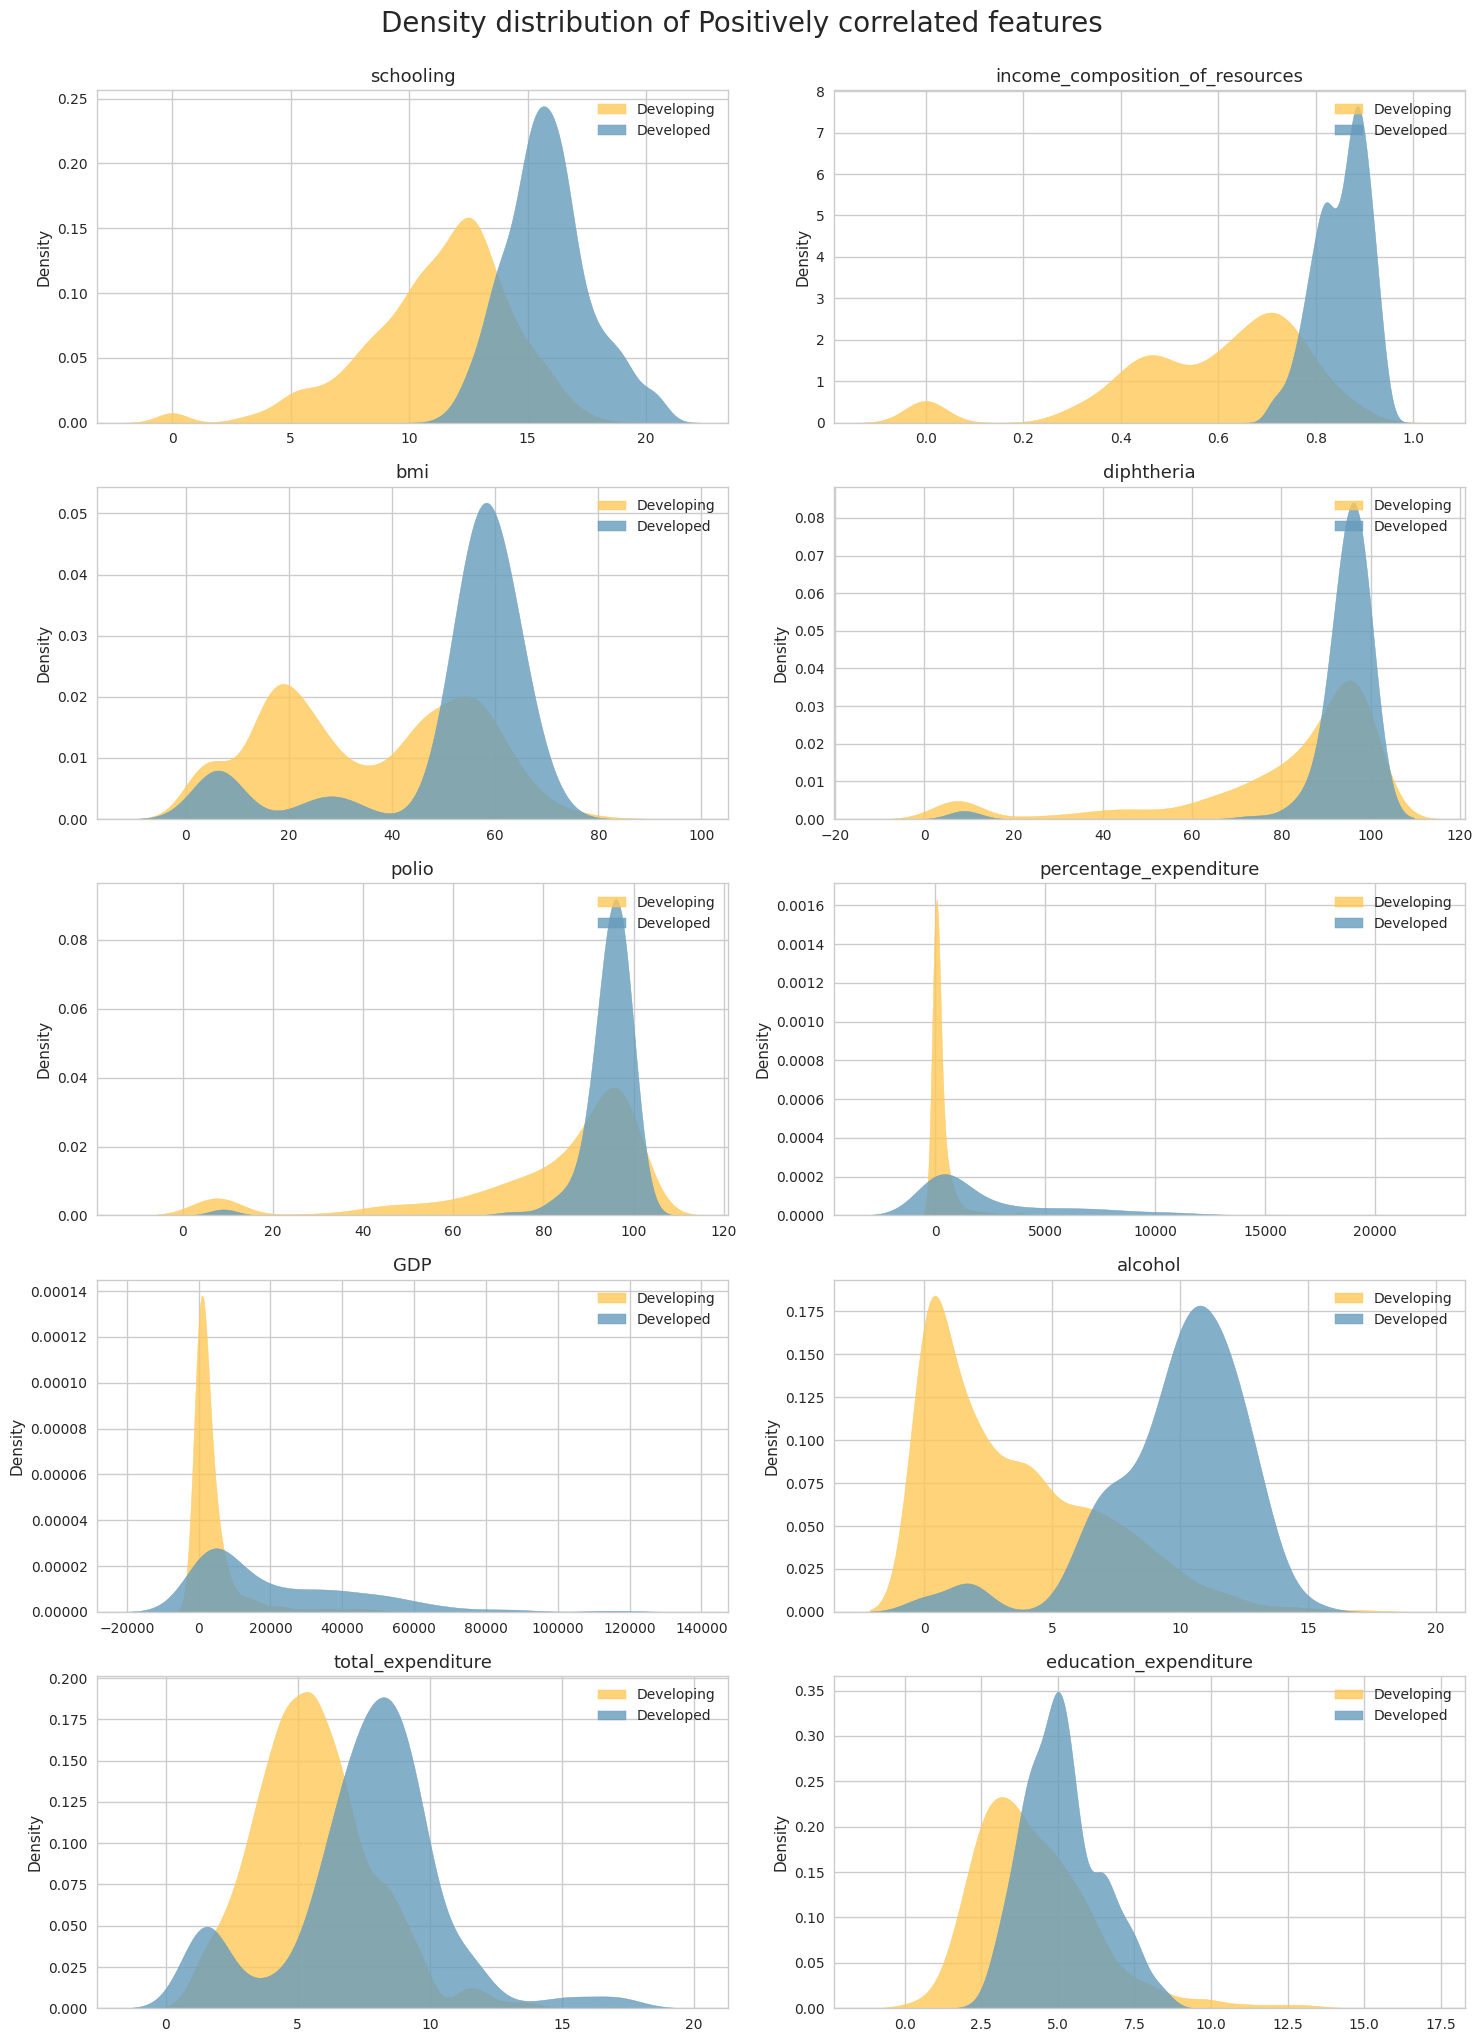

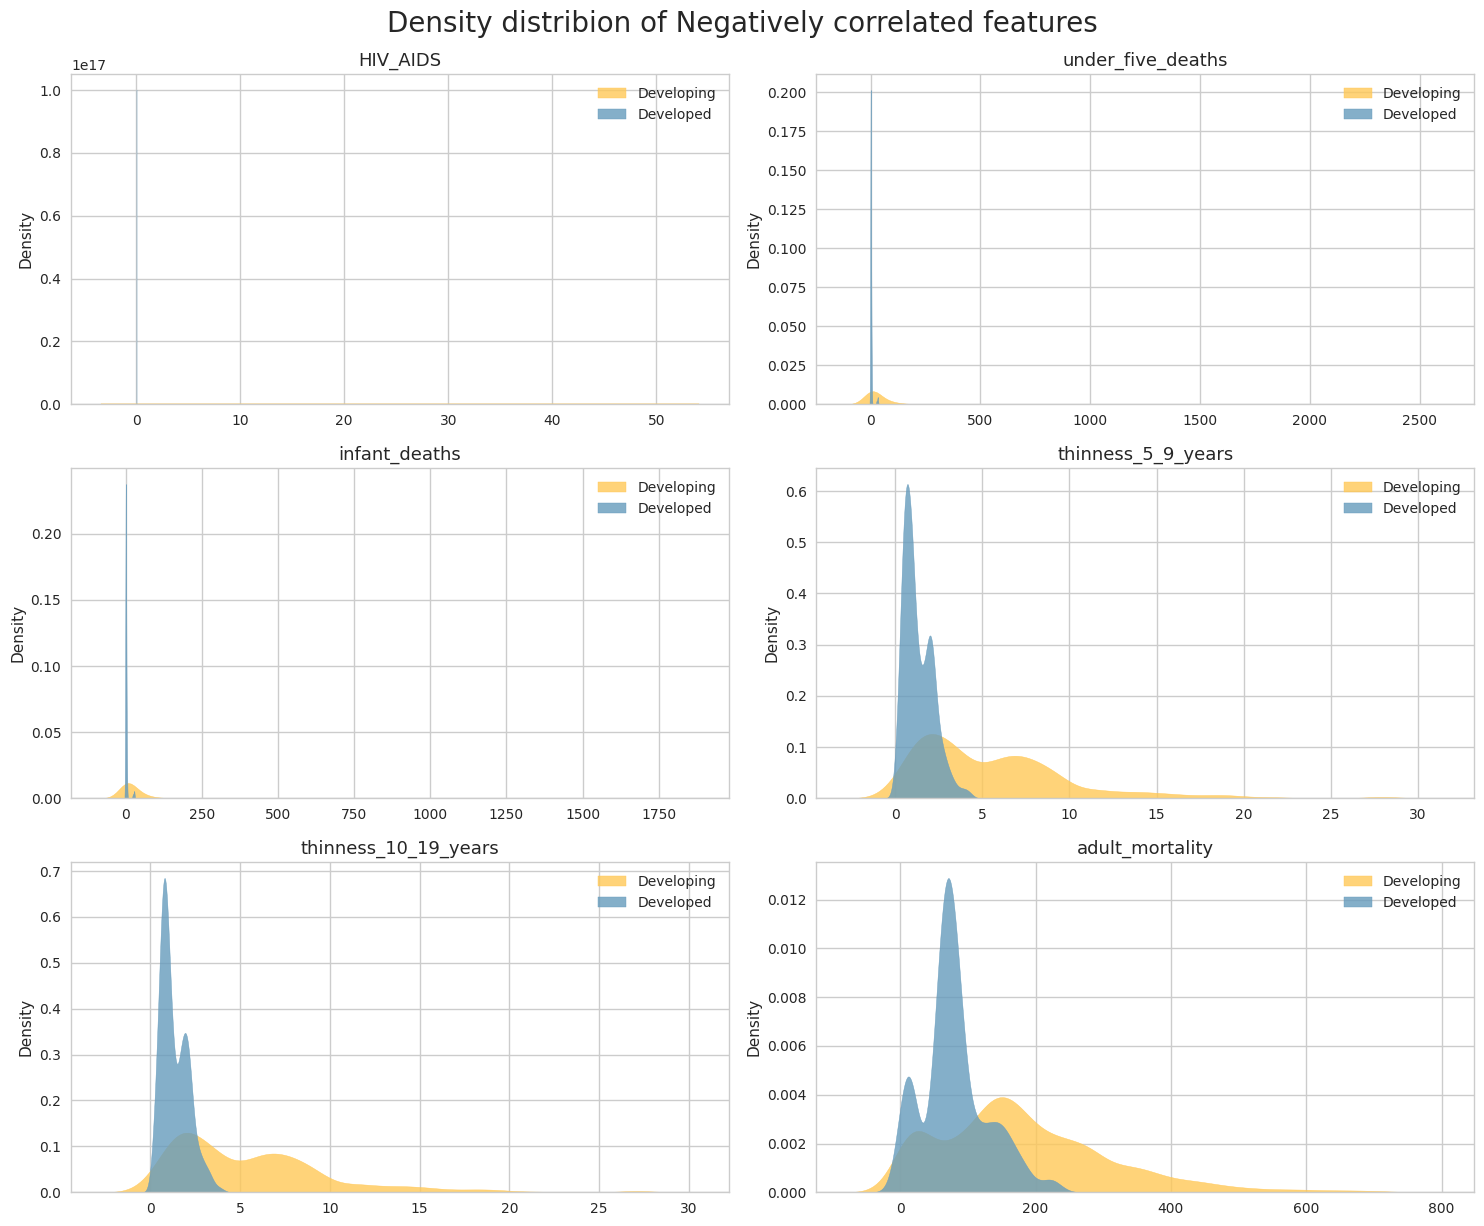

In [59]:
# Define function to plot density distribution of features

def plot_density(df, columns, title):
    rows = int(np.ceil(len(columns)/2))
    fig, axs = plt.subplots(rows, 2, figsize=(15, 4*rows))
    axs = axs.flatten()

    for ax, column in zip(axs, columns):
        for i, status in enumerate(df_le['status'].unique()):
            subset = df_le[df_le['status'] == status]
            # Draw the density plot
            if subset[column].dtype != np.object:
                sns.kdeplot(subset[column], ax=ax,
                            label = status, fill=True, color=[colors[4], colors[1]][i], alpha = 0.8)

        ax.set_title(column, fontsize=13)
        ax.set_xlabel('')
        ax.legend()

    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.02)
    plt.show()

# Plot density distribution of positively correlated features
title = 'Density distribution of Positively correlated features'
plot_density(df_le, positive_corr, title)

# Plot density distribution of negatively correlated features
title = 'Density distribion of Negatively correlated features'
plot_density(df_le, negative_corr, title)

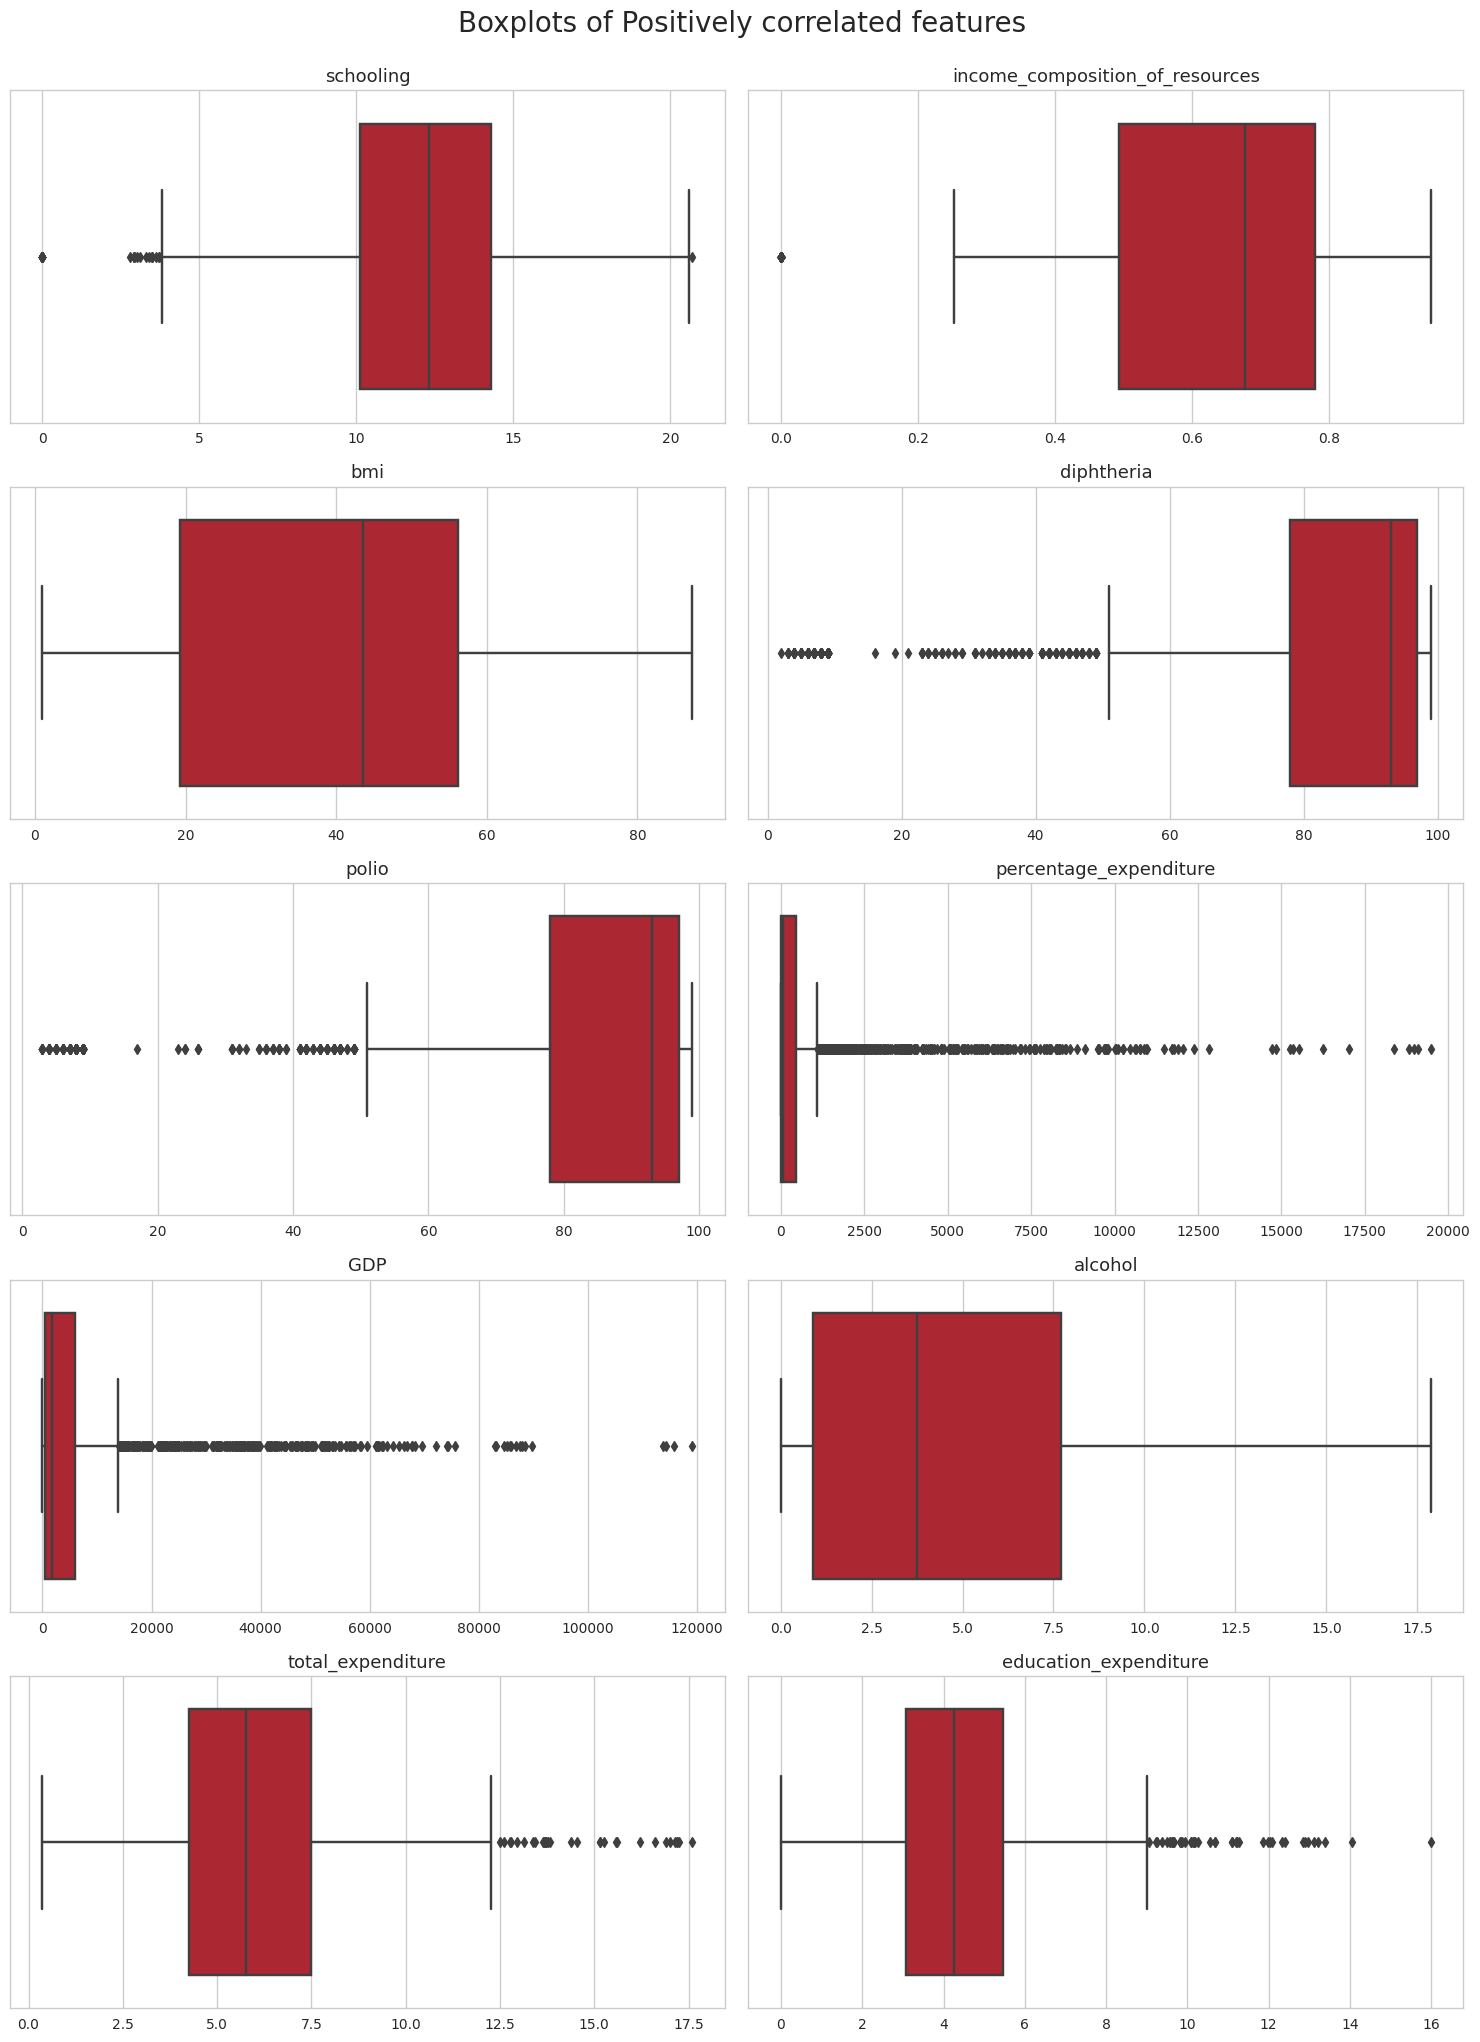

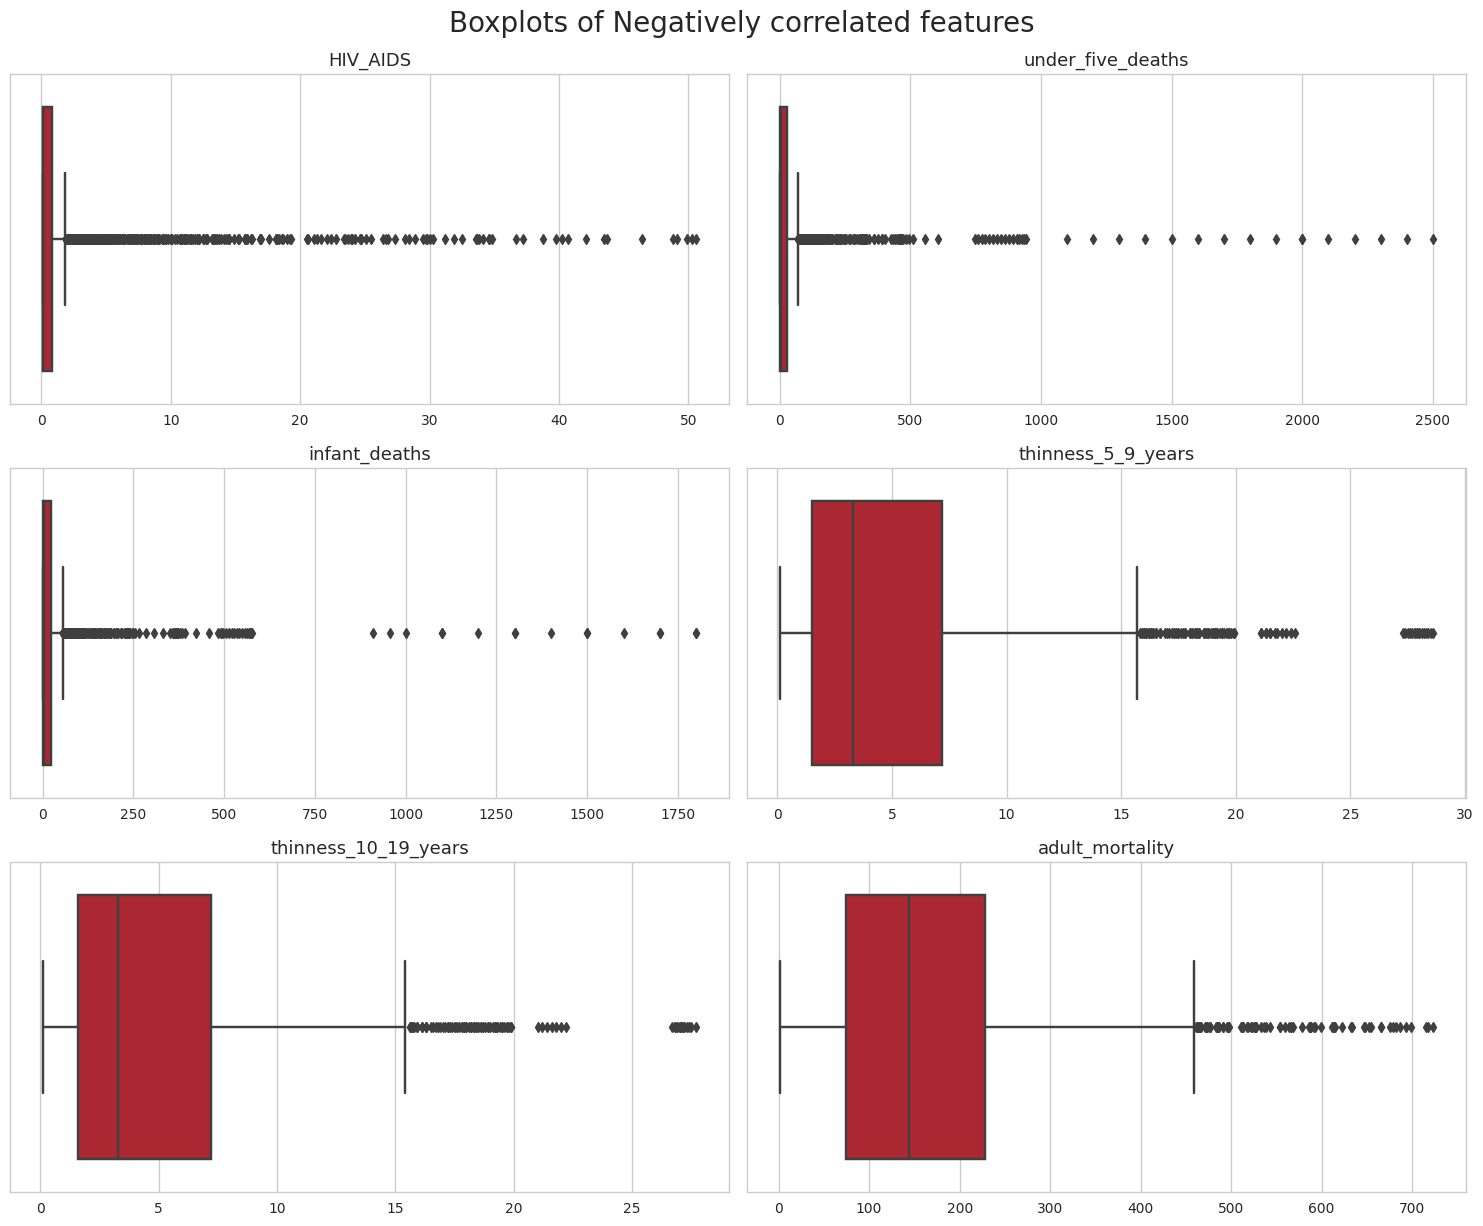

In [60]:
# Define function to plot boxplots of features
def plot_boxplot(df, columns, title='Boxplot of Features'):
    rows = int(np.ceil(len(columns)/2))
    fig, axs = plt.subplots(rows, 2, figsize=(15, 4*rows))
    axs = axs.flatten()

    for ax, column in zip(axs, columns):
        sns.boxplot(x=df[column], data=df, ax=ax, palette=colors)
        ax.set_title(column, fontsize=13)
        ax.set_xlabel('')

    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.02)
    plt.show()

# Plot boxplots of positively correlated features
title = 'Boxplots of Positively correlated features'
plot_boxplot(df_le, positive_corr, title)

# Plot boxplots of negatively correlated features
title = 'Boxplots of Negatively correlated features'
plot_boxplot(df_le, negative_corr, title)

**Overall Insights**

* It was noticeable the distribution of most of these features had their distribution skewed to the left. Hence, suggest the fact that a number of countries have higher range of Life expectancy while a few number of countries have their range lower.

* It was also noticeable that there is an up trend in Life Expectancy over the years from left to right with a few drops with causes identified above for countries with status as Developed and Developing.

* We noticed with the box plots the presence of outliers in several features, for both the positive correlated features and negative correlated features. These outliers not dealt with can influence the performance of predictive models. Even though these might represent unique situations or data entry errors it is strongly advised to handle them.

# Preprocessing

* [Data Cleaning](#section_5_1)
    1. [Missing](#section_3_1)
    2. [Outliers](#section_3_1)
* [Feature Selection/Enineering/Scaling](#section_5_2)
* [Pipeline](#section_5_3)

<br/>

For the sake of readability and maintenance, most of the transformations made in this stage will be inserted into a Pipeline, and the remaining transformations, for practicality reasons, will be included within the preprocessor() function.

In addition, before any transformation in the dataset, the data will be split into training and testing sets. Although the final model would probably perform better if we removed all outliers from the dataset or imputed missing values based on statistical measures of the entire column before the split, this would result in a less robust model for new data. This is because, in production, it is possible to encounter missing data, outliers, and all sorts of noise, so it is necessary for the model to be able to adjust well to these scenarios.

## Data Cleaning

### Handling missing values
It is very crucial in the proprocessing phase of build a model to handle missing values as your results could be skewed or generate errors during modeling.

* Our dataset of for the last 15years is observed to have missing values in most of the columns.
* The strategy here is to implement the Sklearns's class method called **KNNImupter**. This will impute the missing values by using the K-nearest neighbors to predict the missing values.
* This strategy is more effective considering the fact that there might be a pattern to the missing values and is better than using mean values to replacing missing values.

In [88]:
#Missing Values
pd.DataFrame(df_le.isnull().mean().sort_values(ascending=False)*100, columns=['% Missing'])

% Missing
education_expenditure            30.292716
population                       22.191967
hepatitis_b                      18.822328
GDP                              15.248468
total_expenditure                 7.692308
alcohol                           6.603131
income_composition_of_resources   5.684139
schooling                         5.547992
thinness_5_9_years                1.157250
thinness_10_19_years              1.157250
bmi                               1.157250
diphtheria                        0.646698
polio                             0.646698
life_expectancy                   0.340368
adult_mortality                   0.340368
HIV_AIDS                          0.000000
under_five_deaths                 0.000000
country_code                      0.000000
measles                           0.000000
country_name                      0.000000
infant_deaths                     0.000000
income_group                      0.000000
income_group_code                 0.000000
decade                            0.000000
leap_year                         0.000000
year                              0.000000
status                            0.000000
region                            0.000000
percentage_expenditure            0.000000

### Handling Outlies

Data points in a dataset that differ significantly in position from observation as known as outliers. They are presented normally due to variability in the data or errors made for example during collection of the data.

In the above plots we used box plot to visualized the outliers for the positve and negative correlated features. These can greatly affect the accuracy of our prediction especially with regression models. Hence, needs to be handled.

* Our strategy here will be to use Interquartile Range(IQR) to identify outlies below and above using the formular **Q1-(1.5*IQR) AND Q3+(1.5*IQR)** respectively.
* Then after identifying these outliers below and above we replace these ensuring values are consistent with the data distribution using the Class method **KNNImputer**.

In [89]:
df_le.describe()

population        year       decade  life_expectancy  \
count  2.286000e+03      2938.0       2938.0      2928.000000   
mean   1.275338e+07  2007.51872  2003.771273        69.224932   
std    6.101210e+07    4.613841     4.847497         9.523867   
min    3.400000e+01      2000.0       2000.0        36.300000   
25%    1.957932e+05      2004.0       2000.0        63.100000   
50%    1.386542e+06      2008.0       2000.0        72.100000   
75%    7.420359e+06      2012.0       2010.0        75.700000   
max    1.293859e+09      2015.0       2010.0        89.000000   

       adult_mortality  infant_deaths      alcohol  percentage_expenditure  \
count      2928.000000    2938.000000  2744.000000             2938.000000   
mean        164.796448      30.303948     4.602861              738.251295   
std         124.292079     117.926501     4.052413             1987.914858   
min           1.000000       0.000000     0.010000                0.000000   
25%          74.000000       0.000000     0.877500                4.685343   
50%         144.000000       3.000000     3.755000               64.912906   
75%         228.000000      22.000000     7.702500              441.534144   
max         723.000000    1800.000000    17.870000            19479.911610   

       hepatitis_b       measles          bmi  under_five_deaths        polio  \
count  2385.000000        2938.0  2904.000000        2938.000000  2919.000000   
mean     80.940461    2419.59224    38.321247          42.035739    82.550188   
std      25.070016  11467.272489    20.044034         160.445548    23.428046   
min       1.000000           0.0     1.000000           0.000000     3.000000   
25%      77.000000           0.0    19.300000           0.000000    78.000000   
50%      92.000000          17.0    43.500000           4.000000    93.000000   
75%      97.000000        360.25    56.200000          28.000000    97.000000   
max      99.000000      212183.0    87.300000        2500.000000    99.000000   

       total_expenditure   diphtheria     HIV_AIDS            GDP  \
count         2712.00000  2919.000000  2938.000000    2490.000000   
mean             5.93819    82.324084     1.742103    7483.158469   
std              2.49832    23.716912     5.077785   14270.169342   
min              0.37000     2.000000     0.100000       1.681350   
25%              4.26000    78.000000     0.100000     463.935626   
50%              5.75500    93.000000     0.100000    1766.947595   
75%              7.49250    97.000000     0.800000    5910.806335   
max             17.60000    99.000000    50.600000  119172.741800   

       thinness_10_19_years  thinness_5_9_years  \
count           2904.000000         2904.000000   
mean               4.839704            4.870317   
std                4.420195            4.508882   
min                0.100000            0.100000   
25%                1.600000            1.500000   
50%                3.300000            3.300000   
75%                7.200000            7.200000   
max               27.700000           28.600000   

       income_composition_of_resources    schooling  education_expenditure  
count                      2771.000000  2775.000000            2048.000000  
mean                          0.627551    11.992793               4.448799  
std                           0.210904     3.358920               1.889211  
min                           0.000000     0.000000               0.000009  
25%                           0.493000    10.100000               3.088465  
50%                           0.677000    12.300000               4.248395  
75%                           0.779000    14.300000               5.464374  
max                           0.948000    20.700000              15.990000

In [61]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.imputer = KNNImputer(n_neighbors=self.n_neighbors)

    def fit(self, X, y=None):
        self.IQR = X.quantile(0.75) - X.quantile(0.25)
        self.Q1 = X.quantile(0.25)
        self.Q3 = X.quantile(0.75)
        return self

    def transform(self, X):
        X_out = X.copy()
        X_out[((X_out < (self.Q1 - 1.5 * self.IQR)) | (X_out > (self.Q3 + 1.5 * self.IQR)))] = np.nan
        X_out = pd.DataFrame(self.imputer.fit_transform(X_out), columns=X.columns)
        return X_out

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

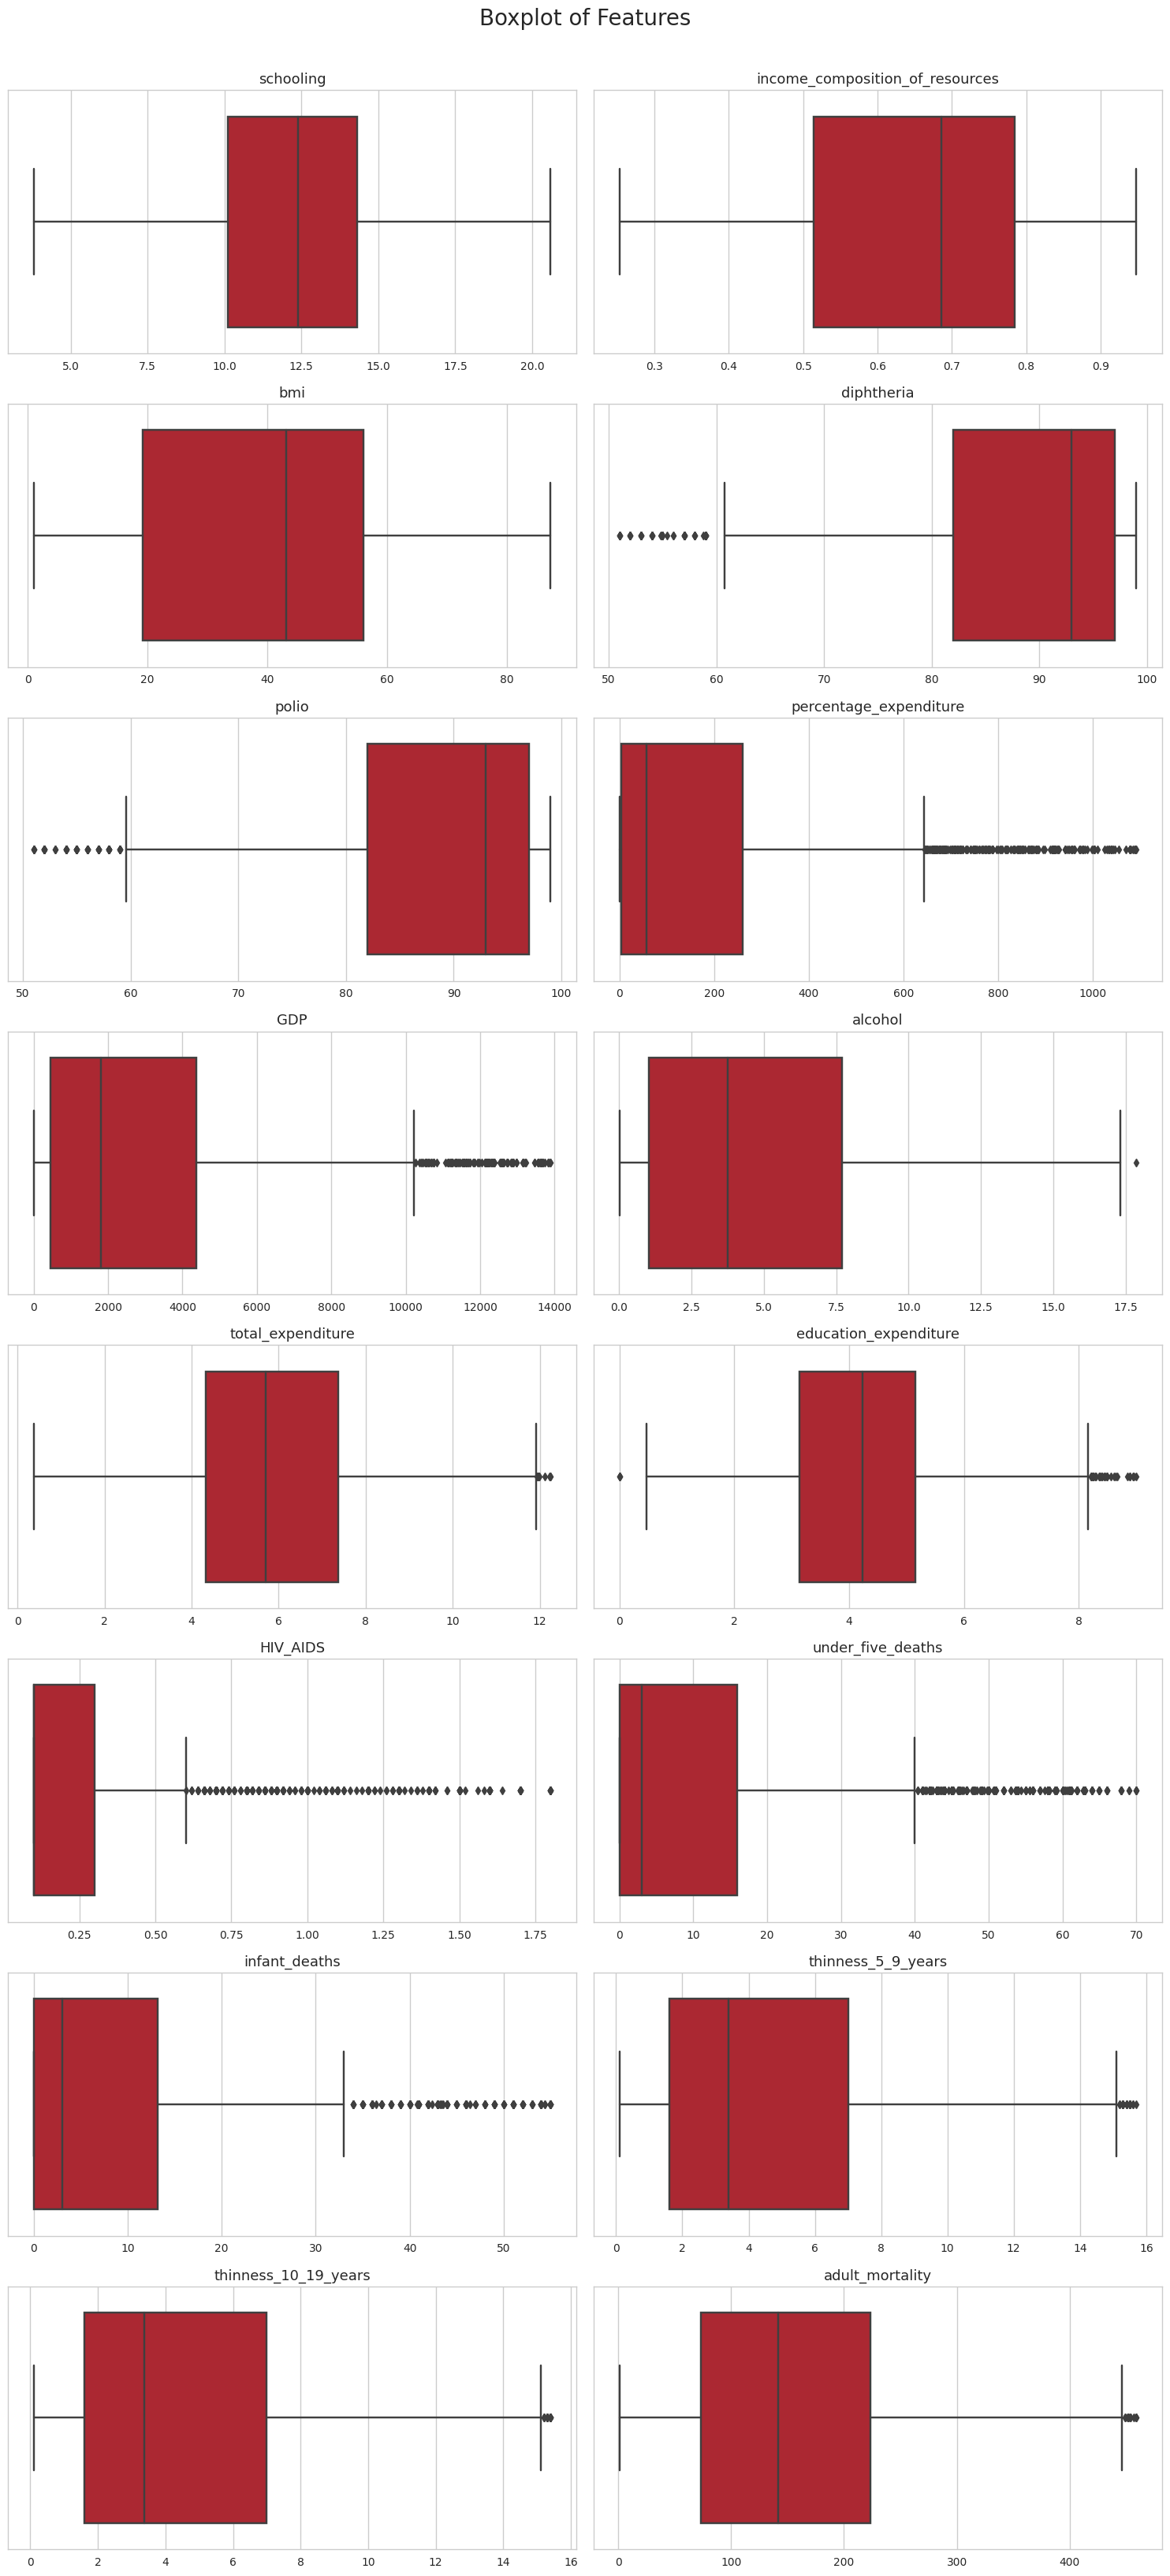

In [62]:
#Select the features
combined_features = positive_corr + negative_corr

#Create df copy of combined selected features
df_combined = df_le[combined_features].copy()

#Create, fit and transform the class OutlierHandler()
handled_outliers = OutlierHandler()
df_handled_outliers = handled_outliers.fit_transform(df_combined)


#Plot boxplot
plot_boxplot(df_handled_outliers, combined_features)


* We can now observer very few outliers than before with the exception of some features namely **'HIV_AIDS', 'GDP', 'infant_deaths','percentage_expenditure'** still having quite alot more values significantly distant. Hence **logarithmic transformation** will be implemented to compress the scale of extreme values converting a the skewed distribution to a normalized distribution for these features

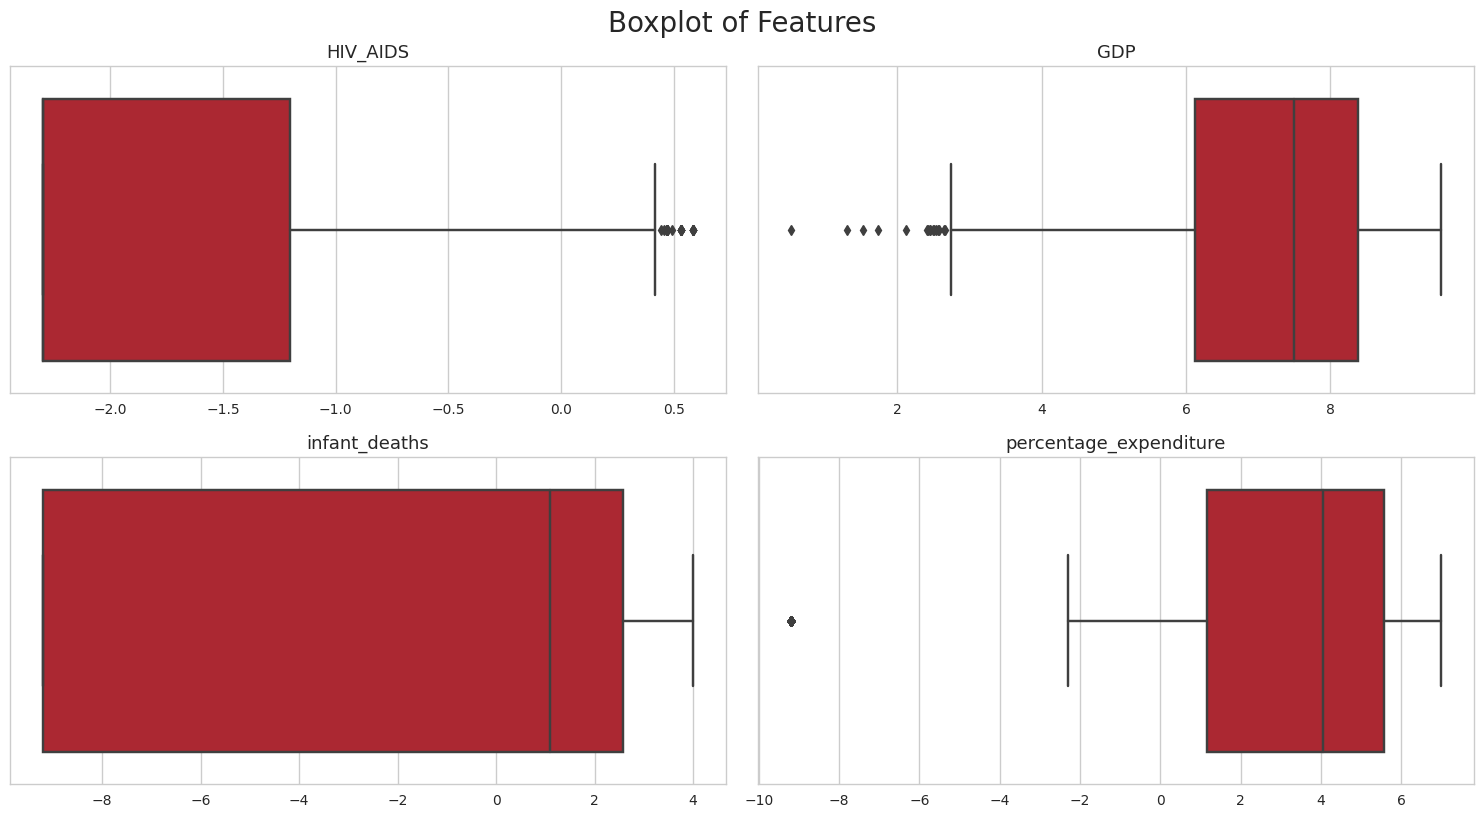

In [63]:
#Apply log transformation
columns_to_log = ['HIV_AIDS', 'GDP', 'infant_deaths','percentage_expenditure']
#, 'diphtheria'
X_train_log = df_handled_outliers[columns_to_log].copy()

X_train_log= X_train_log.apply(lambda x: np.log(x + 10e-5))

plot_boxplot(X_train_log, columns_to_log)

In [92]:
#Missing Values after being handled
pd.DataFrame(df_handled_outliers.isnull().mean().sort_values(ascending=False)*100, columns=['% Missing'])

% Missing
schooling                              0.0
income_composition_of_resources        0.0
bmi                                    0.0
diphtheria                             0.0
polio                                  0.0
percentage_expenditure                 0.0
GDP                                    0.0
alcohol                                0.0
total_expenditure                      0.0
education_expenditure                  0.0
HIV_AIDS                               0.0
under_five_deaths                      0.0
infant_deaths                          0.0
thinness_5_9_years                     0.0
thinness_10_19_years                   0.0
adult_mortality                        0.0

## Feature Engineering/Selection/Scaling

### Feature Engineering
* For feature engineering, this usually involves the creation of new features from existing features to better enhance the models performance. Hence, with our dataset we notice the columns 
**'thinness_5_9_years' and 'thinness_10_19_years'** basically represents the same metric with only the age ranges being different.
* We will therefor create a new feature called **'thinness_5_19_years'** which will be an addition of both **'thinness_5_9_years' and 'thinness_10_19_years'**.

### Feature Selection
* Feature selection is important during preprocessing since not all the features would be beneficial to the model performance.
* In this case we will drop features of no relevance like **'country_code', 'country_name', 'region', 'year', 'leap_year', 'income_group_code', 'income_group', 'decade', 'population', 'status'** and consider the features with high positve and negative correlation with the target.

### Feature Scaling 
* We will use **StandardScaler** to remove the mean and scale to unit variance as the performance of machine learning algorithms work better when numerical features have the same scale.


In [64]:
#Function to split the data and perform the preprocessing.
def preprocessing(df):
    #Create a copy of dataframe.
    df = df.copy()
    
    #Drop rows where target is null
    df.dropna(subset=['life_expectancy'], inplace=True)
    
    #Create new feature 'Thinness 5-19 years'
    df['thinness_5_19_years'] = df['thinness_5_9_years'] + df['thinness_10_19_years']
    df.drop(['thinness_5_9_years', 'thinness_10_19_years'], axis = 1, inplace = True)
    
    #Split the target variable and the features.
    y = df['life_expectancy']
    X = df.drop('life_expectancy', axis=1)
    
    #Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=18) 
    
    #Fill missing with historical mean for each country
    ##The historical_mean is calculated only using X_train data. 
    ###It must be considered that there is no access to the test set.
    for column in X_train.columns[X_train.isna().any()]:
        historical_mean_train = X_train.groupby('country_name')[column].transform('mean')
        X_train[column].fillna(historical_mean_train, inplace=True)
        X_test[column].fillna(historical_mean_train, inplace=True)
    
    
    
    X_train.drop(['country_code', 'country_name', 'region', 'year', 'leap_year', 'income_group_code', 'income_group', 'decade', 'population', 'status'], axis = 1, inplace = True)
    X_test.drop(['country_code', 'country_name', 'region', 'year', 'leap_year', 'income_group_code', 'income_group', 'decade', 'population', 'status'], axis = 1, inplace = True)
    
    return X_train, X_test, y_train, y_test

In [65]:
X_train, X_test, y_train, y_test = preprocessing(df_le)

## Pipeline
A sequence of data preprocessing steps and modeling into a single object bundled together is termed as a pipeline. This also improves on the readability and portability of the code to ensure streamlined workflow.

* In this case, our pipeline consist of grouping the features known to be skewed and all other numerical feature.
* The grouping helps to define tailored piplines for both groups as all would go through **the transformation of handling outliers, imputing missing values with KNNImputer, StandardScaler and modling** but the **Skewed_features** would go throug an extra transformation that is **logarithm transformation**


In [66]:
#Pass this function inside FunctionTransformer instead of passing just np.log to avoid cases with values equal zerodef log_transform(X):
def log_transform(X):    
    return np.log(X + 10e-5)

In [67]:
def pipeline(regressor):
    # define list of features that are known to be skewed in the dataset
    skewed_features = ['HIV_AIDS', 'GDP', 'infant_deaths','percentage_expenditure']
    #, 'diphtheria'
    # define list of numerical features that are not skewed
    numerical_features = [feature for feature in X_train.columns  
                        if feature not in skewed_features]
    
    # define pipeline for numerical features
    numerical_transformer = Pipeline(
        steps=[
            ('outliers', OutlierHandler()), # remove outliers from data
            ('impute', KNNImputer()), # impute missing values using K-Nearest Neighbors
            ('scaling', StandardScaler()), # scale features to have mean 0 and unit variance
        ]
    )
    
    # define pipeline for skewed features
    skewed_transformer = Pipeline(
        steps=[
            ('outliers', OutlierHandler()), # remove outliers from data
            ('log', FunctionTransformer(log_transform)), # apply natural logarithm transformation to skewed features
            ('impute', KNNImputer()), # impute missing values using K-Nearest Neighbors
            ('scaling', StandardScaler()), # scale features to have mean 0 and unit variance
        ]
    )
    
    # define ColumnTransformer to apply each pipeline to appropriate features
    feature_preprocessor = ColumnTransformer(
        transformers=[
            ('numerical_transformer', numerical_transformer, numerical_features), # apply numerical pipeline to numerical features
            ('skewed_transformer', skewed_transformer, skewed_features) # apply skewed pipeline to skewed features
        ],
        remainder='passthrough' # pass through any remaining features
    )

    # define final pipeline, consisting of preprocessor and regressor
    model = Pipeline(
        steps=[
            ('preprocessor', feature_preprocessor), # apply preprocessor to data
            ('regressor', regressor) # apply regressor to preprocessed data
        ]
    )

    return model

## Modeling

* Here, a set of regressors with default parameters will be tested and evaluated. We will then validate the perfomances of these trained models using **cross-validation** to identify models that perform better.

* In this case, our performance metrics will be **Root Mean Squared Error (RMSE), R-squared (R²), Mean Squared Error (MSE), Mean Absolute Error (MAE) and Adjusted R-squared**.

In [68]:
#Dict with the regressors
models = {
    "Linear Regression (Ridge)": pipeline(Ridge()),
    "Decision Tree": pipeline(DecisionTreeRegressor()),
    "Support Vector Regression": pipeline(SVR()),
    "Neural Network": pipeline(MLPRegressor()),
    "Random Forest": pipeline(RandomForestRegressor()),
    "Gradient Boosting": pipeline(XGBRegressor())
}

In [69]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Function that performs cross validation on the model and returns the mean of RMSE, R^2, MSE, MAE, and adjusted R^2.
def evaluate_model(model, X_train, y_train):
    cv = cross_validate(model, 
                        X_train, y_train,
                        cv=5,
                        scoring=('neg_root_mean_squared_error', 'r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'))

    # Calculate adjusted R^2
    n = len(X_train)
    k = X_train.shape[1]
    adjusted_r2 = [r2 - (k-1)/(n-k)*(1-r2) for r2 in cv['test_r2']]
    
    return (np.mean(-cv['test_neg_root_mean_squared_error']),
            np.mean(cv['test_r2']),
            np.mean(-cv['test_neg_mean_squared_error']),
            np.mean(-cv['test_neg_mean_absolute_error']),
            np.mean(adjusted_r2))

In [70]:
# Run all models through cross validation and get the mean of each one.
models_name = []
models_rmse = []
models_r2 = []
models_mse = []
models_mae = []
models_adj_r2 = []

for name, model in models.items():
    rmse, r2, mse, mae, adj_r2 = evaluate_model(model, X_train, y_train)
    models_name.append(name)
    models_rmse.append(rmse)
    models_r2.append(r2)
    models_mse.append(mse)
    models_mae.append(mae)
    models_adj_r2.append(adj_r2)

df_models = pd.DataFrame(data={
    'Mean RMSE in CV': models_rmse,
    'Mean R2 in CV': models_r2,
    'Mean MSE in CV': models_mse,
    'Mean MAE in CV': models_mae,
    'Mean Adjusted R2 in CV': models_adj_r2
}, index=models_name)

In [71]:
#Mean performance of each model in cross-validation.
display(df_models)

Mean RMSE in CV  Mean R2 in CV  Mean MSE in CV  \
Linear Regression (Ridge)         4.018937       0.822161       16.181556   
Decision Tree                     3.955304       0.824888       15.807804   
Support Vector Regression         4.009716       0.822987       16.117006   
Neural Network                    6.154498       0.583251       37.957025   
Random Forest                     2.725638       0.917665        7.468147   
Gradient Boosting                 2.674843       0.921008        7.176104   

                           Mean MAE in CV  Mean Adjusted R2 in CV  
Linear Regression (Ridge)        2.977280                0.820761  
Decision Tree                    2.277565                0.823509  
Support Vector Regression        2.603598                0.821593  
Neural Network                   4.710921                0.579970  
Random Forest                    1.659446                0.917017  
Gradient Boosting                1.735958                0.920386

In [72]:
#Function to plot feature importance provided the models.
def plot_feature_importance(df):   
    
    df = df.sort_values(by = '% Importance',
                                ascending = False).copy()
    
    df_temp = df['% Importance'].sort_values()
    
    display(df)
    
    fig, ax = plt.subplots(figsize=(16,16))

    bar = ax.barh(df_temp.index,
                 df_temp,
                 align = ('center'),
                 color =colors[0],
                 height = 0.9)

    ax.bar_label(bar, fmt = '%.f%%', padding=2)
    ax.set_xlabel('Importance (%)')
    ax.set_title('Feature Importance \n', fontsize=18);

% Importance
total_expenditure                   79.033058
adult_mortality                      3.260437
GDP                                  2.602613
polio                                2.515204
education_expenditure                1.781558
bmi                                  1.755282
infant_deaths                        1.338075
HIV_AIDS                             1.176407
income_composition_of_resources      0.947620
thinness_5_19_years                  0.815193
under_five_deaths                    0.814431
hepatitis_b                          0.776915
diphtheria                           0.716838
schooling                            0.705366
measles                              0.688975
percentage_expenditure               0.575902
alcohol                              0.496117

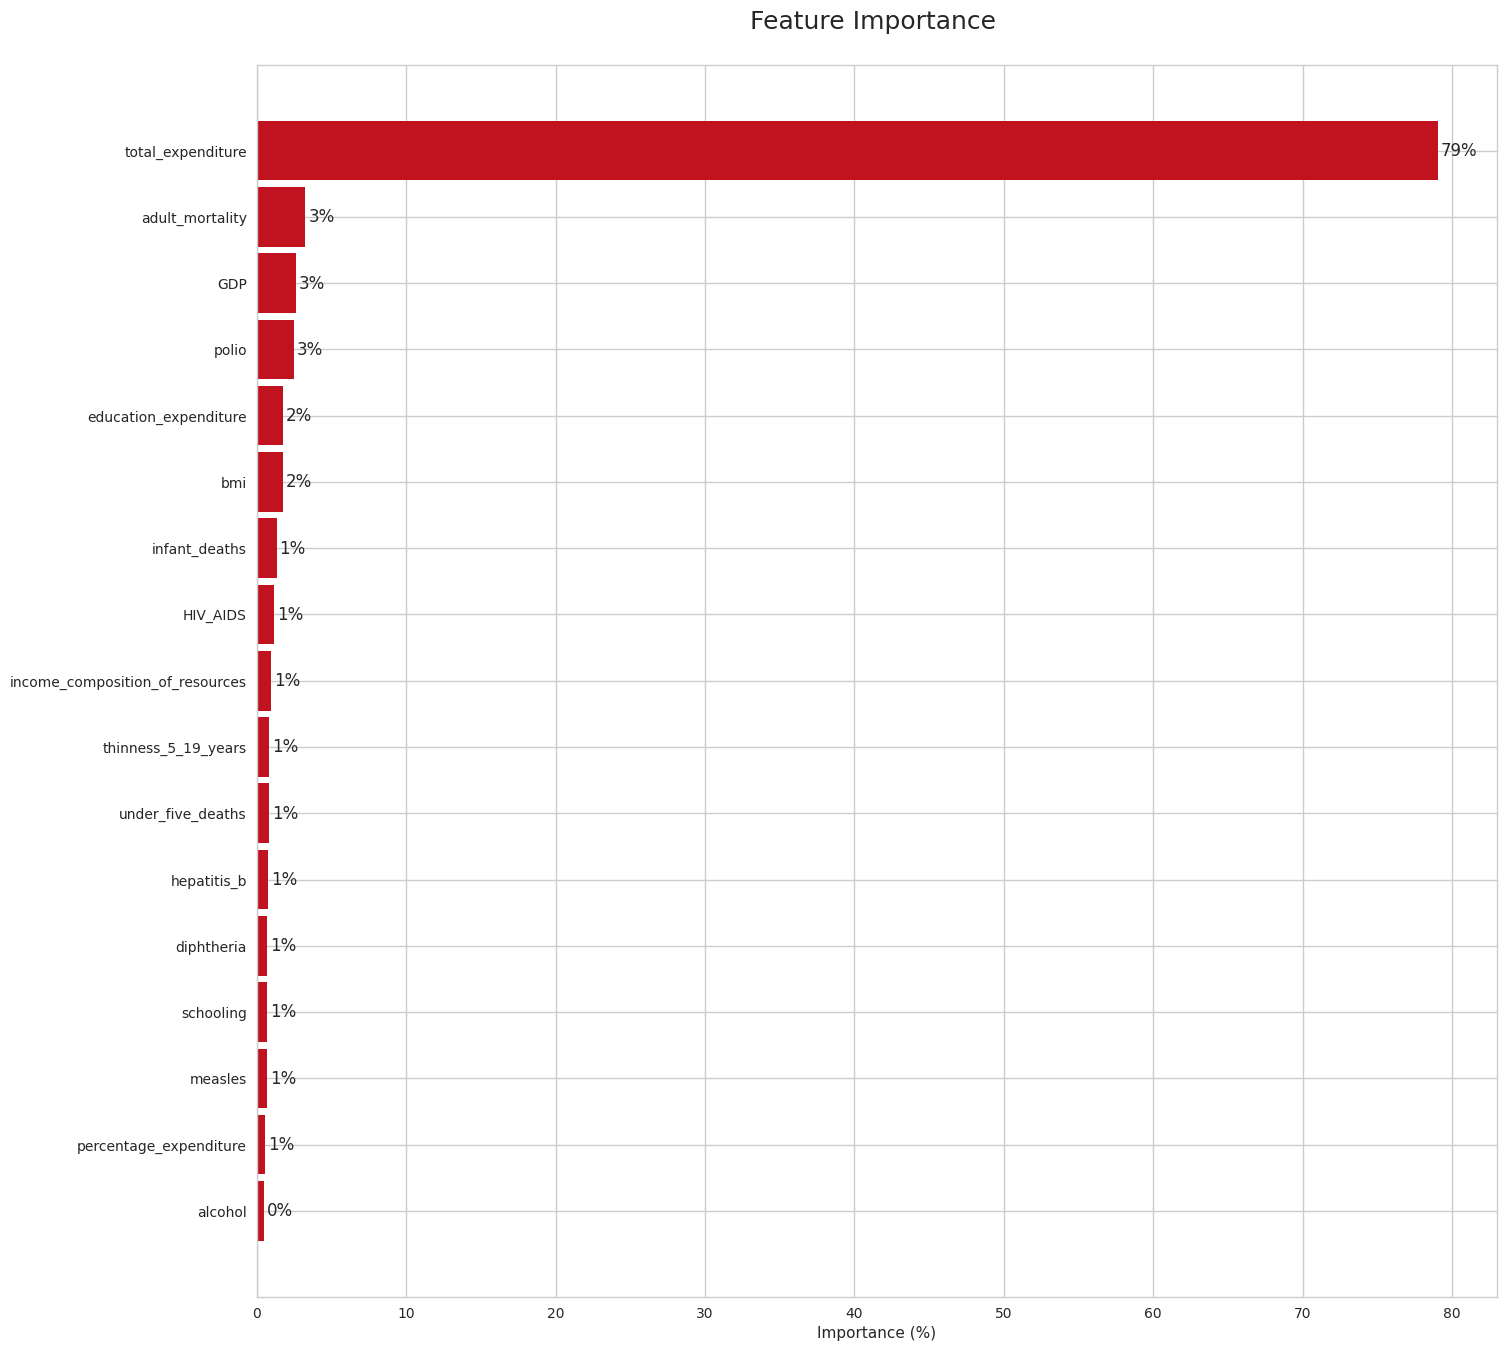

In [73]:
#Check the feature importance for Random Forest Model
models['Gradient Boosting'].fit(X_train, y_train)

df_feature_importance = pd.DataFrame(data = 100* models['Gradient Boosting']['regressor'].feature_importances_, 
                                  index = X_train.columns,
                                  columns = ['% Importance'])

plot_feature_importance(df_feature_importance)

In [74]:
# Make prediction

y_predict = models['Gradient Boosting'].predict(X_test)

In [75]:
y_predict

array([61.554447, 75.020706, 69.53705 , 54.14853 , 56.15236 , 56.51148 ,
       65.56765 , 72.69632 , 80.732445, 82.740685, 72.96706 , 76.71885 ,
       81.35558 , 74.04675 , 71.019264, 59.181957, 82.31329 , 55.20611 ,
       74.49517 , 72.73333 , 82.53967 , 72.2463  , 47.814728, 71.97396 ,
       81.3438  , 80.47859 , 80.74052 , 70.32658 , 76.37395 , 54.00258 ,
       62.898952, 75.48186 , 73.53225 , 72.76308 , 67.68059 , 80.22937 ,
       68.707436, 77.547775, 73.60792 , 74.90213 , 66.09004 , 63.51185 ,
       64.88091 , 56.744934, 55.51833 , 73.71286 , 72.58036 , 72.43722 ,
       77.71681 , 84.76672 , 56.7366  , 74.31341 , 75.00132 , 69.555664,
       82.44631 , 75.287704, 68.33611 , 50.002117, 59.01432 , 73.910194,
       62.457546, 74.92131 , 62.494   , 74.10446 , 65.3656  , 65.85009 ,
       76.02307 , 72.20098 , 52.815033, 68.5439  , 76.15624 , 75.966286,
       79.45546 , 72.024216, 82.668594, 75.4869  , 79.59235 , 66.84684 ,
       55.320427, 81.1595  , 54.978374, 71.88998 , 

In [ ]:
rom sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# Initialize the model
gbm = GradientBoostingRegressor()

# Set up the grid search
grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model with the different hyperparameters
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

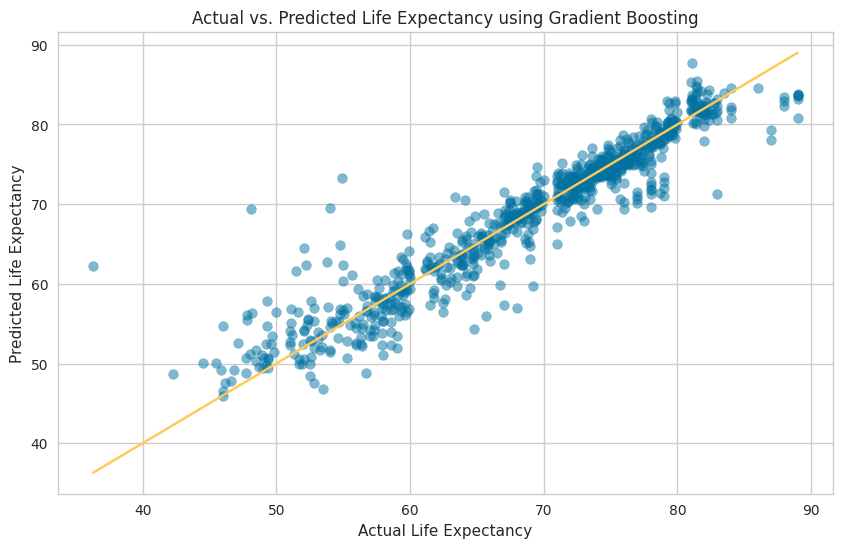

In [76]:
# Plot y_test against y_predict
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color=colors[4])  # Diagonal line
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title(f'Actual vs. Predicted Life Expectancy using Gradient Boosting')
plt.show()

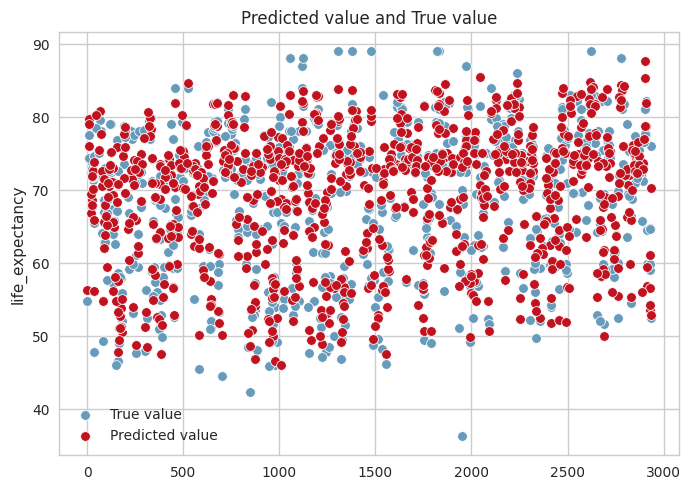

In [77]:
sns.scatterplot(x = X_test.index, y = y_test, color=colors[1], label = "True value")
sns.scatterplot(x = X_test.index, y = y_predict, color=colors[0], label = "Predicted value");

plt.title('Predicted value and True value');

# Conclusion